# Gas Phase UED Fast Analysis
Written by LFH in Dec 2023. 
Adapted from code provided by Yusong Liu and Caidan Moore

1. __Reject images with high counts.__
    * Compared total counts of each image. This is done either based on selected images or based on the standard deviaion of all the images. 
2. __Optional: Subtract background images__
    * Some experiments collect background shots. An average of these is taken and the average is subtracted from each data image. 
    * Alternative method is to generate a background based on the average values of the corners of the images. Right now this is behaving poorly for me.  
3. __Remove outliers instances of identical pixels.__
    * This is generally referred to as removing xray hits or hot pixels. There are two functions for doing this. `rmv_xray_all` runs in parallel and should be used for large datasets and `cleanMean` takes in small data sets.
4. __Mask detector hole__
    * Currently using the code made by collaborators at SLAC as it automatically finds the mask position. This function uses the opencv package. Replaces the mask with nan values.  
    * Only works with small data. Need to figure out why and how to make work with a large data set.  
5. __Calculate static diffraction center.__
    * Using the method provided by collaborators at SLAC found in the `find_beam_center` function. Iteratively fits a circle to the data based on equivalent values in radial positions.  
    * Need to figure out a way to use the individual centers instead of the average. 
6. __Remove radial outliers.__
    * Filter out values which are beyond a threshold compared to equivalent values at other radial positions. This is automatically done in the `azimuthal_avg_correct` function which runs in the background in parallel when calling `get_azimuthal_average`. This function currently uses the multiprocessing package. Would like to switch to concurrent.futures package. __Need to edit__
7. __Apply median filter.__
    * Applies a median filter using the `scipy.ndimage.median_filter` function which requires a set size of grid to filter based on. Before doing this, need to change all nan values to their radial average equivalent.
8. __Calculate azimuthal average.__
    * See point 6. Repeat calculation.


## Import Necessary Functions

In [91]:
# Standard Packages
import numpy as np
from math import exp, sqrt, floor
from tifffile import tifffile as tf
import glob
import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy.ma as ma
import scipy.signal as ss
import scipy.interpolate as interp
from scipy.optimize import curve_fit
from scipy.signal import medfilt2d
from scipy.ndimage import median_filter
from scipy.ndimage import gaussian_filter
from scipy.interpolate import make_interp_spline
import skimage.transform as skt
import concurrent.futures
import matplotlib
%matplotlib widget

#Image stuff
import matplotlib.patches as patches
from PIL import Image
from skimage.filters import threshold_otsu
from skimage.morphology import closing, square
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops_table
from skimage import util
import cv2
from pybaselines import Baseline

#ff stuff
import os
from multiprocessing.dummy import Pool as ThreadPool

## Define Functions

### Processing Files

In [92]:
def get_data(file_path, shape = False, file_names = False):
    """
    Generates an array of images of TIFF files.
    
    Arguments:
    
    file_path (string) = Path containing the UED TIFF files. Path can be for a singular image or for a folder containing
                        many files. See examples below for example using //*// format style.
    shape (bool, optional) = Boolean expression. If set to True, function returns the shape of the image data array.
    file_names (bool, optional) = Boolean Expression. If set to true, function returns the list of file names.
    
    Returns: data_array, shape (if True), file_names (if True)
    
    numpy array or tuple: 
            If shape = False, file_names = False: Returns numpy array containing data from tiff files as a n x shape x shape (shape refers to the
                                dimensions of the TIFF file, typically 1024 x 1024).
            If shape = True: returns tuple. First element is a numpy array containing data from tiff files as a n x shape x shape
                                (shape refers to the dimensions of the TIFF file, typically 1024 x 1024). Second element is the dimensions
                                of the data array as a tuple.
            If file_names = True: returns tuple containing data array and list with file names.
            
    
    Examples:
    
    file_path = "Desktop/Folder/Data_Analysis/20034291//*//*//ANDOR1_*.tif"
    
    >>>fileReading(file_path)
        [[data1], ..., [dataN]]
    
    >>>fileReading(file_path)
        [[data1], ..., [dataN]], (220, 1024, 1024)
    
    Notes:
        - All images must be of same dimension. If images of different shapes needed, either group them by shape and run this function for
            each file shape or create it manually by reading files into a numpy array with dtype = object. Be careful as this can lead to 
            later problems
        - Review "*" notation to read in all files of a singular type. Expedites the process.
    
    """
    files = glob.glob(file_path) #read in file name
    if not files:
        FileNotFoundError(f"file_path input does not contain any TIFF files: {file_path}")
    data_array = tf.imread(files) # construct array containing files
    if shape and file_names:
        return data_array, data_array.shape, files
    elif shape:
        return data_array, data_array.shape
    elif file_names:
        return data_array, files
    else:
        return data_array
    
def stagePosition(file_names, idx_start, idx_end, unique_positions = False ):
    """
    Finds the stage position in the string for every file name in the list of all TIFF files. Requires the user to find the
    index of the first digit and last digit of a single file and assumes all files are formatted identically. It uses these indices
    to retrieve the digits from the file names and stores them in a list. All files must have the exact same number of characters before
    the stage position in the name of the file. If this is an issue, group the file names by preceding characters and run this function
    on each list of files.
    
    If unique_positions = False, it returns the stage positions as a numpy array. If unique_positions = True, it returns a tuple
                        containing an array of the stage positions, an array of the unique stage positions, and an array containing
                        the indices of the unique stage positions in the original array.
    Arguments: 
    
    file_names (list containing strings): List of file names
    idxStart (int): the index of the first digit of the stage position in the file name
    idxEnd (int): the index of the last digit of the stage position in the file name
    unique_positions
    
    Returns: stage_pos, uniq_stage (optional), uniq_stage_idx (optional)
    
    stage_pos (array): Default. A numpy array containing the stage positions of the file. The index of each stage position corresponds to
                            the index of the file name in file_names.
    uniq_stage (array): Optional. A numpy array containing the unique stage positions listed in ascending order.
    uniq_stage_idx (array): Optional. A numpy array containing the indices of the unique stage positions in the original input array.
    
    Examples:
    
    file_names = ['image001_10.tif', 'image002_20.tif', 'image004_40.tif', 'image003_30.tif', 'image004_40.tif']
    >>> stagePosition(file_names, 9, 11)
        [10. 20. 40. 30. 40.]
    
    >>> stagePosition(file_names, 9, 11, unique_positions = True)
        (array([10., 20., 40., 30., 40.]), array([10., 20., 30., 40.]), array([0, 1, 3, 2]))

    """
    try:
        try:
            stage_pos = [np.float64(file_name[idx_start:idx_end]) for file_name in file_names]
            stage_pos = np.array(stage_pos)
            if unique_positions == True:
                uniq_stage, uniq_stage_idx = np.unique(stage_pos, return_index = True)
                return stage_pos, uniq_stage, uniq_stage_idx
            else:
                return stage_pos
            return stagePos
        except ValueError:
            raise ValueError("""Failed to convert a file name to a float. Make sure that index positions are correct for all files in file_names.""")
    except IndexError:
        raise ValueError("Invalid index values. Make sure the index values are within the range of the file name strings.")

def get_counts(data_array, plot = False):
    """
    Generates the counts from the given data by summing over the array elements. Returns 2d array of the same dimension as the
    input images.
    
    Arguments:
    
    data_array (numpy.ndarray): Numpy data array containing the diffraction images.
    plot (bool, optional): If set to true, generates a graph of the counts data.
    
    Returns:
    counts (numpy.ndarray): One dimensional numpy array containing the data after summing over each array element.
    
    Example:
    
    data = np.array([[[1, 2, 3], [4, 5, 6]], [[7, 8, 9], [10, 11, 12]]])
    >>>countData(data)
        array([21, 51])
    """
    counts = np.sum(data_array, axis = (1,2))
    if len(data_array) == 0:
        raise ValueError("Input data_array is empty.")
    if data_array.ndim != 3:
        raise ValueError("Input data_array is not 3 dimensional.")
    if plot == True:
        plt.plot(np.arange(len(data_array[:, 0, 0])), counts)
        plt.show()
    return counts

# def get_image_details(file_names):
#     """
#     Returns the data loaded from the tif files with a floor subtracted based on the median of the corner. Also returns arrays with the stage positions, the
#     file order number, and the number of counts per image.
    
#     Arguments: 
#     data_array (numpy.ndarray): Numpy data array containing the diffraction images.
#     file_names = ['image001_10.tif', 'image002_20.tif', 'image004_40.tif', 'image003_30.tif', 'image004_40.tif']
    
#     Returns:
#     data_array (ndarray): Array of N x 1024 x 1024 where N is the length of tile file_names list. Generated by using tifffile as tf.
#     stage_pos (array): Default. A numpy array containing the stage positions of the file. The index of each stage position corresponds to
#                             the index of the file name in file_names.
#     file_order (array): Returns the image number located in the file name. Reflects the order with which the images are taken. 
#     counts(ndarray): One dimensional numpy array of length N containing the data after summing over each array element.

#     """
#     data_array = tf.imread(file_names) # construct array containing files
    
#     try:
#         stage_pos = []
#         file_order = []
#         try:
#             #stage_pos = [np.float64(file_name[idx_start:idx_end]) for file_name in file_names]
#             #stage_pos = np.array(stage_pos)
#             for file in file_names:
#                 string = list(map(str, file.split("/")))
#                 string = list(map(str, string[-1].split("-")))
#                 file_order.append(int(string[1]))
#                 string = list(map(str, string[-1].split("_")))
#                 stage_pos.append(float(string[0]))
#         except ValueError:
#             raise ValueError("""Failed to convert a file name to a float. Make sure that index positions are correct for all files in file_names. Also check separators""")
#     except IndexError:
#         raise ValueError("Invalid index values. Make sure the index values are within the range of the file name strings.")
    
#     stage_pos = np.array(stage_pos)
#     file_order = np.array(file_order)
    
#     counts = get_counts(data_array)
    
#     return data_array, stage_pos, file_order, counts 


def get_image_details_slac(file_names, sort=True):
    """
    WORKS FOR CURRENT DATA COLLECTION
    Returns the data loaded from the tif files with a floor subtracted based on the median of the corner. Also returns arrays with the stage positions, the
    file order number, and the number of counts per image.
    
    Arguments: 
    data_array (numpy.ndarray): Numpy data array containing the diffraction images.
    file_names = ['image001_10.tif', 'image002_20.tif', 'image004_40.tif', 'image003_30.tif', 'image004_40.tif']
    
    Returns:
    data_array (ndarray): Array of N x 1024 x 1024 where N is the length of tile file_names list. Generated by using tifffile as tf.
    stage_pos (array): Default. A numpy array containing the stage positions of the file. The index of each stage position corresponds to
                            the index of the file name in file_names.
    file_order (array): Returns the image number located in the file name. Reflects the order with which the images are taken. 
    counts(ndarray): One dimensional numpy array of length N containing the data after summing over each array element.

    """
    data_array = tf.imread(file_names) # construct array containing files
    
    try:
        stage_pos = []
        file_order = []
        try:
            #stage_pos = [np.float64(file_name[idx_start:idx_end]) for file_name in file_names]
            #stage_pos = np.array(stage_pos)
            for file in file_names:
                string = list(map(str, file.split("/")))
                string = list(map(str, string[-1].split("_")))
                file_order.append(int(string[2]))
                stage_pos.append(float(string[3]))
        except ValueError:
            raise ValueError("""Failed to convert a file name to a float. Make sure that index positions are correct for all files in file_names. Also check separators""")
    except IndexError:
        raise ValueError("Invalid index values. Make sure the index values are within the range of the file name strings.")
        
        
    stage_pos = np.array(stage_pos)
    file_order = np.array(file_order)
    counts = get_counts(data_array)
    
    if sort == True:
        idx_sort = np.argsort(file_order)
        file_order = file_order[idx_sort]
        data_array = data_array[idx_sort]
        stage_pos = stage_pos[idx_sort]
        counts = counts[idx_sort]
    
    return data_array, stage_pos, file_order, counts 

### Cleaning Functions

In [250]:
def clean_and_filter(data_array):
    """Takes in a 3D array of data and applies the scipy.ndimage.median_filter on them. Need to consider the box size for these filters. 
        Additionally, issues can arise if the data array has nan values. 
        
        Returns: filtered data array of the same size as the input array"""
    
    print("Cleaning data")
    clean_data_array = []
    for data in data_array:
        new_data = data
        filt_data = median_filter(new_data, size=3)
        clean_data_array.append(np.array(filt_data))
    
    return clean_data_array

def _clean_and_filter(data_array_1d):
    """Takes in a large 3D array of data and applies the scipy.ndimage.median_filter on them in parallel processing. 
    Need to consider the box size for these filters. Additionally, issues can arise if the data array has nan values. Eventually would like to add
    A baseline subtraction to this code.

    Returns: filtered data array of the same size as the input array"""
    
    #corners = (np.median(data_array_1d[-50:, -50:]), np.median(data_array_1d[-50:, :50]), np.median(data_array_1d[:50, -50:]), 
                    #np.median(data_array_1d[:50, :50]))
    #floor = float(np.mean(corners))
    new_data = data_array_1d
    filt_data = median_filter(new_data, size=3)
    
    return filt_data


def clean_all(data_array):
    """Takes in a large 3D array of data and applies the scipy.ndimage.median_filter on them in parallel processing using the hidden function
    _clean_and_filter. Need to consider the box size for these filters. Additionally, issues can arise if the data array has nan values. 
    Eventually would like to add a baseline subtraction to this code.

    Returns: filtered data array of the same size as the input array"""
    
    print('Cleaning all data with concurrent.futures.ProcessPoolExecutor')
    filtered_data = []
    with concurrent.futures.ProcessPoolExecutor() as executor:
        results = executor.map(_clean_and_filter, data_array)
        
    for result in results:
        filtered_data.append(result)
    
    filtered_data = np.array(filtered_data)
    print(filtered_data.shape)
    print("Finished cleaning!!")
    return filtered_data

def rmv_xrays_all(data_array):
    """ Requires global variables for the mean and standard deviation. Filters out any pixels that are more than 4 times the standard deviation of 
    the average pixel value by running the hidden function _remove_xrays in parallel. Use cleanMean if not a large dataset.
    
    Returns: xray removed data sets of the same shape."""
    print("Removing xrays from all data")
    clean_data = []
    with concurrent.futures.ProcessPoolExecutor() as executor:
        results = executor.map(_remove_xrays, data_array)
    for result in results:
        clean_data.append(result)
    pct_rmv = []
    for i in range(len(clean_data)):
        no_rmv = sum(sum(clean_data[i].mask))
        pct_rmv.append(no_rmv/(1024*1024) * 100)
    clean_data = np.array(clean_data)
    print(clean_data.shape)
    
    pct_rmv = np.array(pct_rmv)
    plt.figure()
    plt.plot(pct_rmv)
    plt.title("Percent Pixels Removed")
    plt.xlabel("Image Number")
    plt.ylabel("Percent")
    plt.show()
    
    return clean_data
        

def _remove_xrays(data_array_1d):
    upper_threshold = mean_data + 4*std_data
    clean_data = ma.masked_greater_equal(data_array_1d, upper_threshold)
    return clean_data
            
def cleanMean(data_array, std = 4, return_clean_data = True):
    """
    Takes in a data array and calculate the mean and standard deviation at each index across all images. Then applies a filter
    to the data that masks all values (replaces outliers with nan's) outside a given number of standard deviations. After, the 
    mean is taken, returning a 2 dimensional array with the mean data of non-outlier entries across all images.
    
    If return_clean_data is set to True, the cleaned data is returned as a 3d array without having the mean taken.
    
    Arguments:
    
    data_array (numpy.ndarray): Data array containing diffraction image data.
    std (int or float): Number of standard deviations from the mean allowed. Values outside this number of standard deviations
                        are masked as nan's. Set to 3 by default.
                        
    Returns:
    
    clean_mean_data (numpy.ndarray): Default. Returns a 2 dimensional array containing the mean values of the cleaned data.
    clean_data (numpy.ndarray): Other option. Returns the raw 3 dimensional array containing the cleaned data.
    
    Examples:
    
    example_array = np.array([[[8.,2],[1,2]], [[1.,2],[1,2]], [[1.,2],[1,2]], [[1., 2], [1,2]]])
    
    >>> cleanMean(example_array, std=1)
        np.array([[1.,2],[1.,2]])
    
    >>> cleanMean(example_array, std=1, return_clean_data = True)
        np.array([[[np.nan, 2],[1,2]], [[1.,2],[1,2]], [[1.,2],[1,2]], [[1.,2],[1,2]]])
    """
    if len(data_array) == 0:
        raise ValueError("Input data array is empty.")
    if data_array.ndim != 3:
        raise ValueError("Input data array is not 3 dimensional.")
    if std <= 0:
        raise ValueError("Number of standard deviations (std) must be non-negative.")
    if not isinstance(return_clean_data, bool):
        raise TypeError("return_clean_data must be a boolean value.")
   
    mean = np.mean(data_array, axis = 0)
    stDev = np.std(data_array, axis = 0)
    upper_threshold = mean + std*stDev
    #lower_threshold = mean - std*stDev
    clean_data = ma.masked_greater_equal(data_array, upper_threshold)
    #clean_data = ma.masked_outside(data_array, lower_threshold, upper_threshold)
    pct_rmv = []
    for i in range(len(clean_data)):
        no_rmv = sum(sum(clean_data[i].mask))
        pct_rmv.append(no_rmv/(1024*1024) * 100)

    pct_rmv = np.array(pct_rmv)
    plt.figure()
    plt.plot(pct_rmv)
    plt.title("Percent Pixels Removed")
    plt.xlabel("Image Number")
    plt.ylabel("Percent")
    plt.show()
    if return_clean_data == True:
        return clean_data
    else:
        clean_mean_data = np.mean(clean_data, axis = (0))
        return clean_mean_data
    
def medianFilter(data_array, center_top_left_corner, center_border_length, med_filter_range = 3):
    """
    Takes in a data array and applies scipy.signal's median filter. Then replaces the boundary and center values with the
    original values from the input array as to not lose precision in these parts. 
    
    Arguments:
    
    data_array (np.array): 2d Numpy array containing diffraction image data.
    center_top_left_corner (tuple): Tuple containing the row index (integer) and column index (integer) of the top left corner
                                    (lowest_index_row, lowest_index_column)
    center_border_length (int): Length of one side of the square. Must be an integer.
    med_filter_range (int): Must be odd. Initially set to 3. Shape of the square array for median filtering. Using an odd values makes it so that 
    the median filter is centered around the individual point.
    
    Returns:
    
    med_filt_data (2d-array): Array containing the median filtered data.
            
    """
    if not isinstance(data_array, np.ndarray):
        raise ValueError("Input data_array must be a 2D numpy array.")
    if not isinstance(center_top_left_corner, tuple) or len(center_top_left_corner) != 2:
        raise ValueError("Center top left corner must be a tuple of length 2 that contains two integers.")
    if not isinstance(center_border_length, int):
        raise ValueError("center_border_length must be an integer.")
    #if not isinstance(center_top_left_corner[0] + center_border_length < data_array[0,-1]  
    if not (0 <= center_top_left_corner[0] < data_array.shape[0] and
        0 <= center_top_left_corner[1] < data_array.shape[1] and
        center_top_left_corner[0] + center_border_length <= data_array.shape[0] and
        center_top_left_corner[1] + center_border_length <= data_array.shape[1]):
        raise ValueError("""center_top_left_corner is out of bounds or adding center_border_length goes beyond the array.
                     Check that the tuple values are positive integers within the bounds of the data array and that 
                     adding the border length does not result in a value beyond the size of the array.""")
    if not isinstance(med_filter_range, int) and med_filter_range % 2 == 1:
        raise ValueError("med_filter_range must be an odd integer.")

    med_filt_data = ss.medfilt2d(data_array, med_filter_range)
    med_filt_data[0:med_filter_range//2,:] = data_array[0:med_filter_range//2,:]
    med_filt_data[-(med_filter_range//2):0,:] = data_array[-(med_filter_range//2):0,:]
    med_filt_data[:,0:med_filter_range//2] = data_array[:,0:med_filter_range//2]
    med_filt_data[:,-(med_filter_range//2):] = data_array[:,-(med_filter_range//2):]
    row_s, col_s = center_top_left_corner
    row_e, col_e = row_s+center_border_length, col_s+center_border_length
    med_filt_data[row_s:row_e,col_s:col_e] = data_array[row_s:row_e,col_s:col_e]
    return med_filt_data

def backgroundNoise(data_array, bkg_range = 20, remove_noise = False):
    """
    Takes in a 2d data array (using the mean array is recommended) and calculatees the means of the corners. Linearly interpolates values across 2d
    array to generate of background noise values using pandas.DataFrame.interpolate. Returns a two dimensional numpy array with the linearly 
    interpolated background noise.

    Arguments:

    data_array (2d np.ndarray): Data array used to generate the corner values of the background noise.
    bkg_range (int): Side length of square in each corner used for generating mean value. Initially set to 20.
    remove_noise (Bool): If set to true, generated background values are subtracted from the initial input array. Returns cleaned data.
    
    Returns:
    
    bkg_data (2d np.ndarray): Data array containing the linearly interpolated background noise for the image. If remove_noise = True,
                                returned data has background noise removed from original input.
    """
    if not isinstance(data_array, np.ndarray):
        raise ValueError("Input data_array must be a numpy array.")
    if not isinstance(bkg_range, int) and bkg_range > 0:
        raise ValueError("bkg_range must be an integer > 0.")
    if not isinstance(remove_noise, bool):
        raise ValueError("remove_noise must be a boolean.")
    if not (2 * bkg_range < len(data_array[0,:]) and
            2 * bkg_range < len(data_array[:,0])):
        raise ValueError("2 * bkg-range must be less than both the number of rows and the number of columns.")

    empty_array = np.empty(np.shape(data_array))
    empty_array = (ma.masked_array(empty_array, mask = True))
    empty_array[0,0] = np.mean(data_array[0:20,0:20])
    empty_array[-1,0] = np.mean(data_array[-20:,0:20])
    empty_array[0,-1] = np.mean(data_array[0:20,-20:])
    empty_array[-1,-1] = np.mean(data_array[-20:,-20:])
    empty_array = pd.DataFrame(empty_array).interpolate(axis = 0)
    empty_array = pd.DataFrame(empty_array).interpolate(axis = 1)
    bkg_data = pd.DataFrame.to_numpy(empty_array)
    if remove_noise == True:
        return data_array - bkg_data
    else:
        return bkg_data
    
def gaussian_filter_2d(data_array, sig=1):
    """Applies the scipy.ndimage.gaussian_filter() on the 2D data array. Returns filtered images"""
    gf_filtered = gaussian_filter(data_array, sig)
    return gf_filtered

def normalize_to_baseline(data):
    data[:, :25] = np.nan
    data_mean = np.nanmean(data, axis=0)
    norm_factor = np.nansum(data_mean[80:200])
    data_norm = []
    for i in range(len(data)):
        offset = np.nansum(data[i, 80:200])
        norm = data[i]*(norm_factor/offset)
        data_norm.append(norm)
        
    data_norm = np.array(data_norm)
    return data_norm

def power_fit(data_array, x_vals, degree, return_baseline=False):
    if len(data_array.shape) == 2:
        baseline2d = []
        for i in range(len(data_array)):
            temp_data = np.copy(data_array[i])
            idx_nan = ~np.isnan(temp_data)
            coeff = np.polyfit(x_vals[idx_nan],temp_data[idx_nan],degree)
            baseline = np.polyval(coeff,x_vals)
            baseline2d.append(baseline)

        baseline2d = np.array(baseline2d)
        corrected_data = data_array - baseline2d
        
    elif len(data_array.shape) == 1:
        temp_data = data_array
        idx_nan = ~ np.isnan(temp_data)
        coeff = np.polyfit(x_vals[idx_nan], temp_data[idx_nan], 2)
        baseline2d = np.polyval(coeff, x_vals)
        
        corrected_data = data_array - baseline2d
    else:
        print("Data Array must be 1D or 2D array")
    if return_baseline == True:
        return corrected_data, baseline2d
    else:
        return corrected_data
    
def fit_high_s(data_array, x_vals, s_range, return_baseline=False):
    if len(data_array.shape) == 2:
        corrected_data = []
        baseline = []
        for i in range(len(data_array)):
            temp_data = data_array[i]
            coeff = np.polyfit(x_vals[s_range], temp_data[s_range], 2)
            line = np.polyval(coeff, x_vals[s_range])
            baseline.append(line)
            data_array[i, s_range] = temp_data[s_range] - line
            corrected_data.append(data_array[i])
            
    elif len(data_array.shape) == 1:
        coeff = np.polyfit(x_vals[s_range], data_array[s_range], 1)
        baseline = np.polyval(coeff, x_vals)
        
        corrected_data = data_array - baseline
    else:
        print("Data Array must be 1D or 2D array")
    
    corrected_data= np.array(corrected_data)
    
    if return_baseline == True:
        return corrected_data, baseline
    else:
        return corrected_data
    

### Masking Functions

In [101]:
def detectorMask(data_array, hole_center, inner_radius, outer_radius, plot_image = True):
    """
    Takes in a 2d data array and applies a circular (donut shaped) detector mask to it, replacing the masked values with np.nan's.
    Returns the masked, 2d data array.

    Arguments:
    
    data_array (2d np.ndarray): 2d data array to be masked.
    hole_center (tuple): Tuple containing the x and y coordinates of the center of the image, each one of which an int.
    inner_radius (float): Inner radius. Values within the radius of this drawn from the center are masked.
    outer_radius (float): Outer radius of the donut. Values outside the radius of this drawn from the center are masked.
    plot_image (bool, optional): If True, plots the masked image. Default is False.

    Returns:
    ring_data (2d np.ndarray): Data array with the circular detector mask applied.
    """
    if not isinstance(hole_center, tuple) or len(hole_center) != 2:
        raise ValueError("hole_center must be a tuple of length 2 containing the x and y coordinates of the hole center.")
    if not (isinstance(inner_radius, (int, float)) and inner_radius > 0):
        raise ValueError("inner_radius must be a positive float or integer.")
    if not (isinstance(outer_radius, (int, float)) and outer_radius > 0):
        raise ValueError("outer_radius must be a positive float or integer.")
    if inner_radius >= outer_radius:
        raise ValueError("inner_radius must be smaller than outer_radius.")


    hole_cx, hole_cy = hole_center
    x_idx, y_idx = np.meshgrid(np.arange(data_array.shape[2]), np.arange(data_array.shape[1]))
    dist = np.sqrt(((x_idx - hole_cx)**2 + (y_idx-hole_cy)**2))
    mask = np.logical_and(dist<=outer_radius, dist>= inner_radius)
    ring_data = []
    for i in range(len(data_array)):
        data = np.where(mask, data_array[i], np.nan)
        ring_data.append(data)
        
    ring_data = np.array(ring_data)
    if plot_image == True:
        img3 = plt.imshow(ring_data[0])
        plt.colorbar(img3)
    return(ring_data)

    
def mask_hole(I,fit_bor,hole_bor,value_bor,show='yes'):
       
    [X_fit,Y_fit]=np.where((I[fit_bor[0][0]:fit_bor[0][1],fit_bor[1][0]:fit_bor[1][1]]<1.1*value_bor) &
                           (I[fit_bor[0][0]:fit_bor[0][1],fit_bor[1][0]:fit_bor[1][1]]>0.9*value_bor))
    if show=='yes':
        plt.scatter(Y_fit+fit_bor[1][0],X_fit+fit_bor[0][0])
    center_hole,r_hole=fit_circle([X_fit+fit_bor[0][0],Y_fit+fit_bor[1][0]])
    
    mask=np.ones((hole_bor[0][1]-hole_bor[0][0],hole_bor[1][1]-hole_bor[1][0])).astype(float)
    for xi in range(len(mask)):
        for yi in range(len(mask[xi])):
            if (xi-center_hole[0]+hole_bor[0][0])**2 + (yi-center_hole[1]+hole_bor[1][0])**2 <= (r_hole+3)**2:
                mask[xi,yi]=np.nan
    I[hole_bor[0][0]:hole_bor[0][1],hole_bor[1][0]:hole_bor[1][1]]=I[hole_bor[0][0]:hole_bor[0][1],hole_bor[1][0]:hole_bor[1][1]]*mask
    
    return mask,center_hole,r_hole

### Center Finding

In [102]:
# def find_beam_center(I,center=[500,500],r=175,printr2='no',recursiontime=0):

#     recursiontime+=1
#     #up down right left,r away pixles average
#     fit_value=np.average([I[center[0]+r][center[1]],I[center[0]-r][center[1]],I[center[0]][center[1]+r],I[center[0]][center[1]-r]])
    
#     [X_f,Y_f]=np.where((I>0.999*fit_value) & (I<1.001*fit_value))
    
#     #plt.figure()
#     #plt.scatter(Y_f,X_f)
#     #plt.imshow(I)
#     a=len(X_f)
#     i=0
#     #delete fit_points which are too far away from fit_circle, range from 0.5r to 1.5r
#     while(i<a):
#         ri2=(X_f[i]-center[0])**2+(Y_f[i]-center[1])**2
#         if (ri2>(1.5*r)**2) or (ri2<(0.5*r)**2):
#             X_f=np.delete(X_f,i)
#             Y_f=np.delete(Y_f,i)
#             i-=1
#             a-=1
#         i+=1
#     center_new,r_new=fit_circle([X_f,Y_f],printr2)
    
#     if r_new==0:
#         return [0,0]
#     elif ((center[0]-center_new[0])**2 +(center[1]-center_new[1])**2) <=1 :
#         #new center pretty close to old center
#         return center_new
#     elif recursiontime>=10:
#         return [0,0]
#     else:
#         #else: iterate
#         return find_beam_center(I,center_new,r_new,recursiontime=recursiontime)
    
    
    
# def fit_circle(fit_points,printr2='yes'):
    
#     #circle function: ax+by+c=-(x^2+y^2)
    
#     A=np.empty((len(fit_points[0]),3))
#     B=np.empty(len(fit_points[0]))
    
#     for i in range(len(fit_points[0])):
#         B[i]=-(fit_points[0][i]**2+fit_points[1][i]**2)
#         A[i][0]=fit_points[0][i]
#         A[i][1]=fit_points[1][i]
#         A[i][2]=1
    
#     #A[i]=[xi,yi,1], B[i]=-(xi^2+yi^2), par=[a,b,c]
#     #namely A*par=B, least square method
#     if np.linalg.det(np.dot(A.T,A)) == 0:
#         return [],0
#     par=np.dot(np.dot(np.linalg.inv(np.dot(A.T,A)),A.T),B)
    
#     #correlation coeff, if not very close to 1(less than 3 nines), be careful
#     if printr2=='yes':
#         y_ave=np.mean(B)
#         r2=np.sum((np.dot(A,par)-y_ave)**2)/np.sum((B-y_ave)**2)
#         print(r2)
    
#     center_new=[round(-par[0]/2),round(-par[1]/2)]
#     r_new=round(np.sqrt(par[0]**2+par[1]**2-4*par[2])/2)
    
#     return center_new,r_new


def find_beam_center(I,center=[500,500],r=200,printr2='no',recursiontime=0):

    recursiontime+=1
    #up down right left,r away pixles average
    # fit_value=average([I[center[0]+r][center[1]],I[center[0]-r][center[1]],I[center[0]][center[1]+r],I[center[0]][center[1]-r]])
    fit_value= np.average([I[round(center[0])+r][round(center[1])],I[round(center[0])-r][round(center[1])],I[round(center[0])][round(center[1])+r],I[round(center[0])][round(center[1])-r]])

    [X_f,Y_f]= np.where((I>0.999*fit_value) & (I<1.001*fit_value))

    a=len(X_f)
    i=0
    #delete fit_points which are too far away from fit_circle, range from 0.5r to 1.5r
    while(i<a):
        ri2=(X_f[i]-center[0])**2+(Y_f[i]-center[1])**2
        if (ri2>(1.5*r)**2) or (ri2<(0.5*r)**2):
            X_f=np.delete(X_f,i)
            Y_f=np.delete(Y_f,i)
            i-=1
            a-=1
        i+=1
            
    center_new,r_new=fit_circle([X_f,Y_f],printr2)
    
    if r_new==0:
        return [0,0]
    elif ((center[0]-center_new[0])**2 +(center[1]-center_new[1])**2) <=1 :
        #new center pretty close to old center
        return center_new
    elif recursiontime>=10:
        return [0,0]
    else:
        #else: iterate
        return find_beam_center(I,center_new,r_new,recursiontime=recursiontime)
    
    
    
def fit_circle(fit_points,printr2='yes'):
    
    #circle function: ax+by+c=-(x^2+y^2)
    
    A= np.empty((len(fit_points[0]),3)) # Find center for 3 thimes
    B= np.empty(len(fit_points[0]))
    
    for i in range(len(fit_points[0])):
        B[i]=-(fit_points[0][i]**2+fit_points[1][i]**2)
        A[i][0]=fit_points[0][i]
        A[i][1]=fit_points[1][i]
        A[i][2]=1
    
    #A[i]=[xi,yi,1], B[i]=-(xi^2+yi^2), par=[a,b,c]
    #namely A*par=B, least square method
    if np.linalg.det(np.dot(A.T,A)) == 0:
        return [],0
    par=np.dot(np.dot(np.linalg.inv(np.dot(A.T,A)),A.T),B)
    
    #correlation coeff, if not very close to 1(less than 3 nines), be careful
    if printr2=='yes':
        y_ave=np.mean(B)
        r2=sum((np.dot(A,par)-y_ave)**2)/sum((B-y_ave)**2)
        print(r2)
    
    center_new=[(-par[0]/2),(-par[1]/2)] # no-Round the center, not working for the moment
    r_new=round(np.sqrt(par[0]**2+par[1]**2-4*par[2])/2) # no-round the r range, not working for the moment
    # print('ct found:'+str(center_new))
    
    # center_new=[round(-par[0]/2),round(-par[1]/2)] # Round the center
    # r_new=round(sqrt(par[0]**2+par[1]**2-4*par[2])/2) # round the r range
    
    return center_new,r_new

### Azimuthal Averaging

In [103]:
def azimuthal_integration(data_array, center, correction_factor=3):
    """
    Performs azimuthal integration over the data set, removing radial outliers as it performs the integration. 
    Function coverts to polar coordinates, the calculates the mean and std at every radial distance (distances are
    previously round to the nearest positive integer and grouped by integer). Returns the azimuthal integration data
    and the azimuthal error.
    
    Arguments:
    
    data_array (np.ndarray): Two dimensional numpy array containing the diffraction image. 
    center (tuple): Tuple containing the integer coordinates of the image center.
    correction_factor (int, optional): Number of standard deviations set as threshold. Preset to 3.
    
    Return: (azi_dat, azi_err)
    
    azi_dat (np.ndarray): Array containing the integrated data.
    azi_err (np.ndarray): Array containing the error of the integrated data.
    
    Example:
    
    sample_array = np.random.rand(100,100)
    center = (40,40)
    
    >>> azimuthal_integration(sample_array, center, correction_factor = 2)
        azi_dat, azi_err
    """

    
    x_mat, y_mat = np.meshgrid(np.arange(0,data_array.shape[1],1)-center[1],np.arange(0,data_array.shape[0],1)-center[0])
    #rmat, _ = cart2pol(xmat, ymat)
    
    r_mat = np.sqrt(x_mat**2 + y_mat**2)
    #phi = np.arctan2(y_mat,x_mat)
                               
    rmat = np.around(r_mat)
    data_array = data_array.astype(float)
    data_array[data_array==0] = np.nan
    x_length = int(np.amax([np.amax(abs(x_mat)),np.amax(abs(y_mat))]))
    azi_dat = np.zeros(x_length)
    azi_err = np.copy(azi_dat)
    for i in range(x_length):
        roi = data_array[r_mat==int(i+1)].astype(float)
        #print(roi)
        if len(roi)==0:
            break
        std = np.nanstd(roi)
        idxx = np.logical_and(roi <= np.nanmean(roi)+correction_factor*std,roi >=np.nanmean(roi)-correction_factor*std)
        idxx = util.invert(idxx)
        roi[idxx] = np.nan
        
        azi_dat[i] = np.nanmean(roi)
        azi_err[i] = np.nanstd(roi)/np.sqrt(abs(np.nansum(roi)))
    return azi_dat, azi_err

def azimuthal_avg_correct(args):
    """Returns the azimuthal average of a diffraction image based on the radial distance of the x, y positions in the image."""
    data, x, y = args
    r_max=len(x)
    I=np.empty(r_max)
    for ri in range(r_max):
        I_r=data[x[ri],y[ri]]
        ave=np.nanmean(I_r)
        sigma=np.nanstd(I_r)
        I_r[np.abs(I_r-ave)>=5*sigma]=np.nan
        I[ri]=np.nanmean(I_r)
    return I

def get_azimuthal_average(data,x,y):
    """Runs the azimuthal average function in parallel for large data sets."""
    p = ThreadPool(3)
    I=p.map(azimuthal_avg_correct, [(data_i,x,y) for data_i in data]) 
    return np.array(I)

def get_average_old(array):
    """Return the average and standard deviation of an array"""
    Sum = 0
    Sum_squared = 0
    for element in array:
        if element == None:
            continue # Skip empty values
        Sum += element
        Sum_squared += element**2
    length = len(array)
    if length == 0:
        return 0, 0
    average = Sum / length 
    stdev = sqrt(Sum_squared / length - average**2) # sigma^2 = <X^2> - <X>^2
    return average, stdev

def get_average(array):
    average = np.nanmean(array)
    stdev = np.nanstd(array)
    return average, stdev

def get_radial_distribution(image):
    """Get average radial intensity after eliminating outliers"""
    radial_range = int(min(X_CENTER, Y_CENTER, GRID_SIZE-X_CENTER, GRID_SIZE-Y_CENTER)) #half the size of the image i.e. 512 for 1024 by 1024 image
    radial_values = [[] for r in range(radial_range)]
    # First get all pixel values for each radial position as an array that we can average over later
    # It will look like
    #   [ (R = 0 values) [...],
    #     (R = 1 values) [...],
    #     (R = 2 values) [...], etc ]

    for Y in range(GRID_SIZE):
        for X in range(GRID_SIZE):
            R = sqrt((X - X_CENTER)**2 + (Y - Y_CENTER)**2)
            R_index = int(round(R))
            if R_index < len(radial_values):
                radial_values[R_index].append(image[X][Y])
    # So now we have an array where, for each R value, we have a sub-array of each pixel intensity at that R
    # We want to first calculate the average and standard deviation
    # Then eliminate all outliers that are >3sigma away from the average
    # Then re-calculate the average with all outliers removed
    radial_averages, radial_stdevs = [], []
    for r_values in radial_values:
        avg, stdev = get_average(r_values)
        # Create new list with outliers removed
        new_r_values = [r if abs(avg - r) <= 5*stdev else np.nan for r in r_values]
        new_avg, new_stdev = get_average(new_r_values)
        radial_averages.append(new_avg)
        radial_stdevs.append(new_stdev)
    
    return radial_averages, radial_stdevs

def remove_radial_outliers(image):
    """After finding average radial values, replace all outlier pixels with the average value at that radius"""
    radial_avgs, radial_stdevs = get_radial_distribution(image)

    new_image = [[0 for Y in range(GRID_SIZE)] for X in range(GRID_SIZE)] # image of all zeros

    for Y in range(GRID_SIZE):
        for X in range(GRID_SIZE):
            R = sqrt((X - X_CENTER)**2 + (Y - Y_CENTER)**2)
            # Calculate the interpolated value for the average and stdev at this R
            # (Same thing I do in simulate_image but now I'm calculating the weighted average of the 
            # average intensity values so the language is a little confusing)
            interpolated_avg, interpolated_stdev = 0, 0 # Will be filled in with the interpolated values

            R_lower = floor(R)
            R_upper = R_lower + 1
            if R_lower >= len(radial_avgs):
                interpolated_avg = 0 # R value is out of bounds, default to 0
                interpolated_stdev = 0
            elif R_upper >= len(radial_avgs):
                interpolated_avg = radial_avgs[R_lower] # R value is just outside of bounds, default to edge value
                interpolated_stdev = radial_stdevs[R_lower]
            else:
                # Calculate weighted average
                interpolated_avg = (R - R_lower) * radial_avgs[R_upper] + (R_upper - R) * radial_avgs[R_lower]
                interpolated_stdev = (R - R_lower) * radial_stdevs[R_upper] + (R_upper - R) * radial_stdevs[R_lower]
            
            if abs(image[X][Y] - interpolated_avg) <= 3*interpolated_stdev:
                # Value is within acceptance range, do not change
                new_image[X][Y] = image[X][Y] 
            else:
                # Value is outside acceptance range, use average value instead
                new_image[X][Y] = interpolated_avg
    
    return new_image

## Reading in Data and Visualizing

### Defining path -- Uses * to make more accessible for reading in multiple scan files

In [127]:
#dataPath = '/work/centurion/shared/UED_data/FY18_o-nitrophenol/20180823/Run/20180823_0320'
#dataPath = '/work/centurion/shared/UED_data/FY18_o-nitrophenol/20180623/Run/20180623_2349'
#runPath = "/*/*/ANDOR1_*.tif"

#dataPath = '/sdf/data/lcls/ds/ued_testfac/data/ueduu10004/NMP/20231214/Run/20231214_1729'

dataPath = '/sdf/data/lcls/ds/ued_testfac/data/ueduu10004/NMP/20231214/Run/20231214_2303'

#dataPath = '/sdf/data/lcls/ds/ued_testfac/data/ueduu10004/NMP/20231213/Run/20231213_1636'
#dataPath = '/sdf/data/lcls/ds/ued_testfac/data/ueduu10004/NMP/20231212/Run/20231212_2046/'
runPath = '/*/ANDOR1_*.tif'

bkg_path = '/sdf/data/lcls/ds/ued_testfac/data/ueduu10004/NMP/20231212/Run/20231212_2034/*/ANDOR1_*.tif'


newPath = dataPath + runPath
print(newPath)
print(bkg_path)

files = glob.glob(newPath) 
bkg_files = glob.glob(bkg_path)
print(len(files))
print(len(bkg_files))

/sdf/data/lcls/ds/ued_testfac/data/ueduu10004/NMP/20231214/Run/20231214_2303/*/ANDOR1_*.tif
/sdf/data/lcls/ds/ued_testfac/data/ueduu10004/NMP/20231212/Run/20231212_2034/*/ANDOR1_*.tif
7806
89


### Plotting Example Image

Load a image to check the signal level: /sdf/data/lcls/ds/ued_testfac/data/ueduu10004/NMP/20231214/Run/20231214_2303/images-ANDOR1/ANDOR1_Delay_2815_208.8875_0001.tif
Total number of images in the chosen directory is 7806


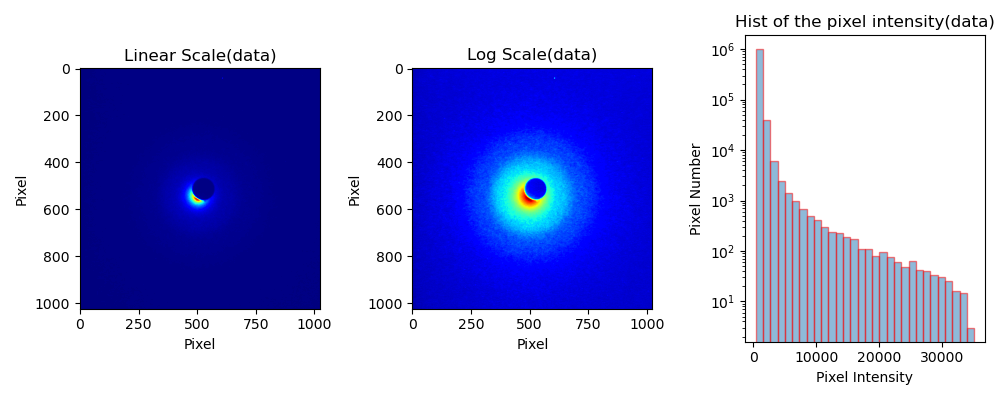

In [128]:
test=tf.imread(files[0]);
bkg_sign='no'
print('Load a image to check the signal level: '+files[0]);
print('Total number of images in the chosen directory is ' + str(len(files)));

# Load or not load the bkg signal
if bkg_sign == 'Yes':
    print('Load background signal');
    data_bkg, _, _, _ = get_image_details(bkg_files) # Load bkg images
    test_bkg = tf.imread(bkg_files[0])
    bkg_dlys_ave = np.nanmean(data_bkg,axis=0) # averaging all the images to optain one image

# Plot a testing figure and check the intensity
plt.figure(figsize=(10,4))

if bkg_sign == 'Yes': # Plot both the data and the background images
    plt.subplot(2,3,1);
    plt.imshow(test,cmap='turbo');
    plt.colorbar()
    plt.xlabel('Pixel');
    plt.ylabel('Pixel');
    plt.title('Linear Scale(data)')
    
    plt.subplot(2,3,2);
    plt.imshow(np.log(test),cmap='turbo');
    plt.colorbar()
    plt.xlabel('Pixel');
    plt.ylabel('Pixel');
    plt.title('Log Scale(data)')
    
    plt.subplot(2,3,3);
    plt.hist(test.reshape(-1),bins=30,edgecolor="r",histtype="bar",alpha=0.5)
    plt.xlabel('Pixel Intensity');
    plt.ylabel('Pixel Number');
    plt.title('Hist of the pixel intensity(data)');
    plt.yscale('log')
    
    plt.subplot(2,3,4);
    plt.imshow(test_bkg,cmap='turbo');
    plt.colorbar()
    plt.xlabel('Pixel');
    plt.ylabel('Pixel');
    plt.title('Linear Scale(bkg)')
    
    plt.subplot(2,3,5);
    plt.imshow(np.log(test_bkg),cmap='turbo');
    plt.colorbar()
    plt.xlabel('Pixel');
    plt.ylabel('Pixel');
    plt.title('Log Scale(bkg)')
    
    plt.subplot(2,3,6);
    plt.hist(test_bkg.reshape(-1),bins=30,edgecolor="r",histtype="bar",alpha=0.5)
    plt.xlabel('Pixel Intensity');
    plt.ylabel('Pixel Number');
    plt.title('Hist of the pixel intensity(bkg)');
    plt.yscale('log')
    
else:
    plt.subplot(1,3,1);
    plt.imshow(test,cmap='jet');
    plt.xlabel('Pixel');
    plt.ylabel('Pixel');
    plt.title('Linear Scale(data)')
    
    plt.subplot(1,3,2);
    plt.imshow(np.log(test),cmap='jet');
    plt.xlabel('Pixel');
    plt.ylabel('Pixel');
    plt.title('Log Scale(data)')
    
    plt.subplot(1,3,3);
    plt.hist(test.reshape(-1),bins=30,edgecolor="r",histtype="bar",alpha=0.5)
    plt.xlabel('Pixel Intensity');
    plt.ylabel('Pixel Number');
    plt.title('Hist of the pixel intensity(data)');
    plt.yscale('log')
plt.tight_layout()
plt.show()

tf.imwrite("Raw_data_ex.tif", test)

### Reading in All Data and Getting Total Counts -- Lauren's Version

In [189]:
%%time


print('Load diffraction signal');
test_data, stage_positions, file_numbers, counts = get_image_details(files[:], sort=True)

#good_range = np.concatenate((np.arange(0, 2500, 1), np.arange(2800, 3300, 1)))
#good_range = np.concatenate((np.arange(0, 250, 1), np.arange(500, 750, 1)))
good_range = np.arange(0, 5000, 1)
filter_data = 'yes'

if filter_data == 'yes':
    test_data = test_data[good_range]
    stage_positions = stage_positions[good_range]
    counts = counts[good_range]
    file_numbers = file_numbers[good_range]

counts_mean = np.mean(counts)        # Mean values of Total Counts of all images
counts_std  = np.std(counts)         # the STD of all the tc for all the iamges
uni_stage = np.unique(stage_positions)# Pump-probe stage position


print('Image number read: ', len(counts))
print('Stage positions: ', len(uni_stage))
#print(file_numbers)

Load diffraction signal
Image number read:  5000
Stage positions:  39
CPU times: user 32.1 s, sys: 1min 36s, total: 2min 8s
Wall time: 2min 28s


### Visualizing Data Info

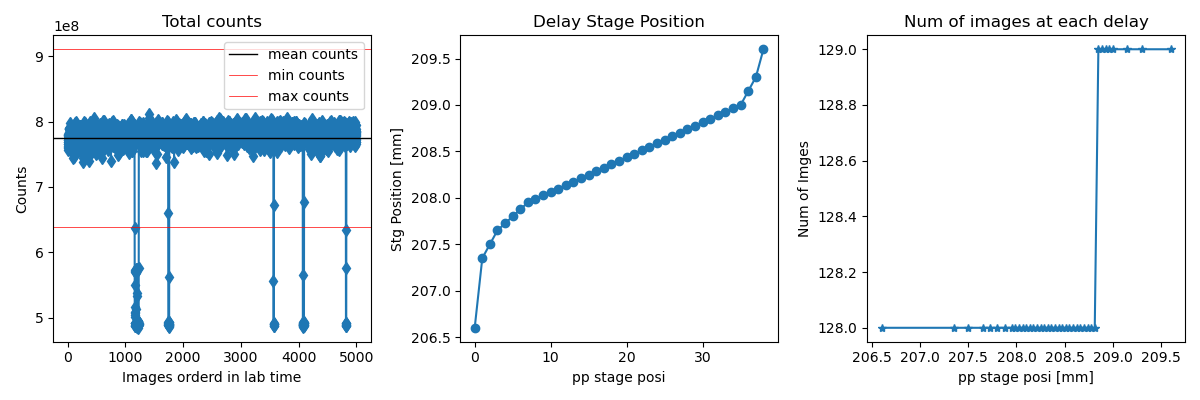

In [190]:
fig = plt.figure(figsize = (12,4)) # Plot counts rate, images number at each posi, and bad images

plt.subplot(1,3,1)
plt.plot(file_numbers, counts,'-d')
plt.axhline(y = counts_mean, color = 'k', linestyle = '-',linewidth=1, label="mean counts");
plt.axhline(y = counts_mean-(3*counts_std), color = 'r', linestyle = '-',linewidth=0.5, label="min counts");
plt.axhline(y = counts_mean+(3*counts_std), color = 'r', linestyle = '-',linewidth=0.5, label="max counts");
plt.xlabel('Images orderd in lab time');
plt.ylabel('Counts');
plt.legend()
plt.title('Total counts');

plt.subplot(1,3,2) # Histogram the number of images at each posi
plt.plot(uni_stage,'-o');
plt.xlabel('pp stage posi');
plt.ylabel('Stg Position [mm]');
plt.title('Delay Stage Position');

plt.subplot(1,3,3) # Histogram the number of images at each posi
posi_edges_bins = np.append(uni_stage-0.001,uni_stage[-1])
posi_hist,posi_edges = np.histogram(stage_positions,bins=posi_edges_bins)
plt.plot(uni_stage,posi_hist,'-*')
plt.xlabel('pp stage posi [mm]');
plt.ylabel('Num of Imges');
plt.title('Num of images at each delay');

plt.tight_layout()
plt.show()

## Filtering Out Bad Shots Based on Total Counts

Either remove shots based on the standard deviation of the total counts or manually select which files to remove based on the image number.  
Based on location of "good" shots. 

In [191]:
# Decide to use threshold or selected images
#test_data = good_data
remove_std = True 
if remove_std is True:
    # Auto find out the bad images by filtering on the total counts
    tc_good = np.squeeze(np.where(abs(counts-counts_mean)<3*counts_std)) # Find out the indices of the low counts images
    good_data = test_data[tc_good]
    good_stage = stage_positions[tc_good]
    good_counts = counts[tc_good]
    good_files = file_numbers[tc_good]
else:
    # Manual find out the bad images by checking the tc from last figure
    tc_good = np.concatenate((np.arange(0, 923, 1), np.arange(926, 1319, 1), np.arange(1322, 2113, 1), np.arange(2261, len(test_data), 1)))
    good_data=test_data[tc_good]
    good_stage = np.squeeze(stage_positions[tc_good])
    good_counts = counts[tc_good]

print(len(good_data))



4870


## Averaging Based on Image Number

In [97]:
grp_sz = 50
groups = np.arange(0, len(good_files)+1, grp_sz)
data = []
image_number = []
for i in range(len(groups)-1):
    ave_data = np.mean(good_data[groups[i]:groups[i+1]], axis=0)
    print("Averaging group: ", groups[i], "-", groups[i+1])
    data.append(ave_data)
    image_number.append(good_files[groups[i]])
    
data = np.array(data)
print(data.shape)

Averaging group:  0 - 50
Averaging group:  50 - 100
Averaging group:  100 - 150
Averaging group:  150 - 200
Averaging group:  200 - 250
Averaging group:  250 - 300
Averaging group:  300 - 350
Averaging group:  350 - 400
Averaging group:  400 - 450
Averaging group:  450 - 500
Averaging group:  500 - 550
Averaging group:  550 - 600
Averaging group:  600 - 650
Averaging group:  650 - 700
Averaging group:  700 - 750
Averaging group:  750 - 800
Averaging group:  800 - 850
Averaging group:  850 - 900
Averaging group:  900 - 950
Averaging group:  950 - 1000
Averaging group:  1000 - 1050
Averaging group:  1050 - 1100
Averaging group:  1100 - 1150
Averaging group:  1150 - 1200
Averaging group:  1200 - 1250
Averaging group:  1250 - 1300
Averaging group:  1300 - 1350
Averaging group:  1350 - 1400
(28, 1024, 1024)


In [98]:
%%time

x_centers = []
y_centers = []
for i in range(len(data)):
    center = find_beam_center(data[i],center=[500,500],r=200)
    x_centers.append(center[0])
    y_centers.append(center[1])
    if i%1==0:
        print('Found center of ' + str(center)+' of group ' + str(i))
x_centers = np.array(x_centers)
y_centers = np.array(y_centers)
centers = x_centers, y_centers
x_ave = np.mean(x_centers[np.where(x_centers > 0)[0]])
y_ave = np.mean(y_centers[np.where(y_centers > 0)[0]])
x_centers[np.where(x_centers == 0)[0]] = x_ave
y_centers[np.where(y_centers == 0)[0]] = y_ave
center_ave = x_ave, y_ave
print(r'Averaged ctr is ' + str(center_ave))

Found center of [543, 506] of group 0
Found center of [543, 506] of group 1
Found center of [543, 506] of group 2
Found center of [544, 506] of group 3
Found center of [543, 506] of group 4
Found center of [543, 506] of group 5
Found center of [543, 506] of group 6
Found center of [543, 506] of group 7
Found center of [543, 506] of group 8
Found center of [543, 506] of group 9
Found center of [542, 506] of group 10
Found center of [544, 506] of group 11
Found center of [543, 507] of group 12
Found center of [544, 506] of group 13
Found center of [543, 506] of group 14
Found center of [543, 506] of group 15
Found center of [543, 506] of group 16
Found center of [544, 506] of group 17
Found center of [543, 506] of group 18
Found center of [544, 506] of group 19
Found center of [544, 506] of group 20
Found center of [542, 506] of group 21
Found center of [544, 507] of group 22
Found center of [544, 506] of group 23
Found center of [544, 506] of group 24
Found center of [543, 506] of group

/tmp/ipykernel_3759929/654476627.py:7: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(np.mean(data, axis=0)));


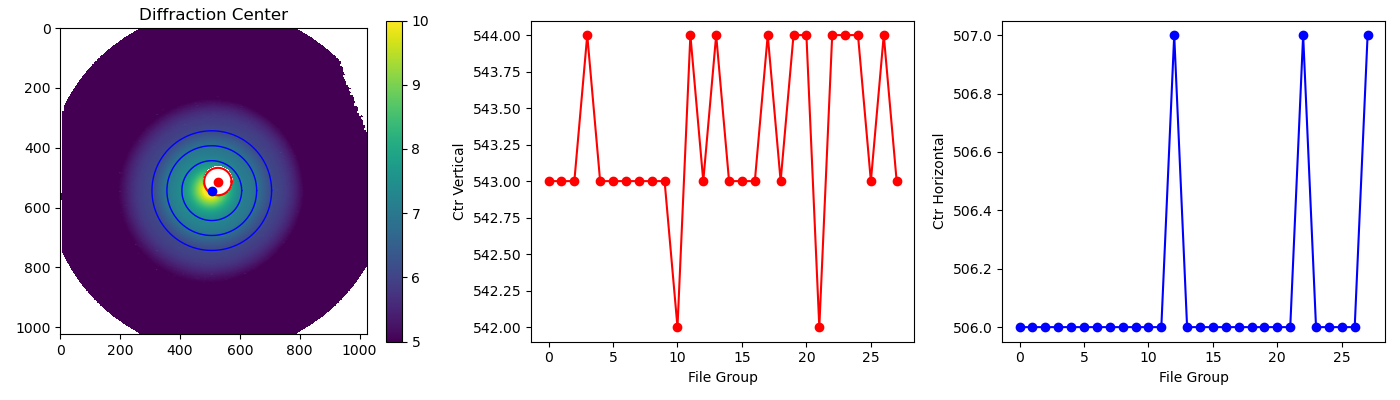

In [99]:
theta = np.linspace(0, 2 * np.pi, 200)
x = np.cos(theta)*hole[2]+hole[0];
y = np.sin(theta)*hole[2]+hole[1];
plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
plt.imshow(np.log(np.mean(data, axis=0)));
plt.colorbar()
plt.plot(x,y,'r',hole[0],hole[1],'or',center_ave[1],center_ave[0],'ob');
for i in range(3):
    x = np.cos(theta)*(i+2)*50+center_ave[1];
    y = np.sin(theta)*(i+2)*50+center_ave[0];
    plt.plot(x,y,linewidth=1,color='b');
plt.clim([5,10]);
plt.title('Diffraction Center')

plt.subplot(1,3,2)
plt.plot(centers[0],'-or');
plt.xlabel('File Group');
plt.ylabel('Ctr Vertical');

plt.subplot(1,3,3)
plt.plot(centers[1],'-ob');
plt.xlabel('File Group');
plt.ylabel('Ctr Horizontal');

plt.tight_layout()
plt.show();

In [100]:
X_CENTER = center_ave[0]
Y_CENTER = center_ave[1]
#X_CENTER = 539
#Y_CENTER = 505
GRID_SIZE = 1024

pointer = np.empty((1024,1024))
for i in range(GRID_SIZE):
    for j in range(GRID_SIZE):
        pointer[i,j]=int(np.sqrt((i-X_CENTER)**2+(j-Y_CENTER)**2))
img_r_max = int(min(X_CENTER, Y_CENTER, GRID_SIZE-X_CENTER, GRID_SIZE-Y_CENTER))
x=[];y=[]
for ri in range(img_r_max):
    [X_temp,Y_temp]=np.where(pointer==ri)
    x.append(X_temp)
    y.append(Y_temp)
print(r'max Q index is ' + str(img_r_max));
r_max=len(x)

azi_data = get_azimuthal_average(data, x, y)

max Q index is 480


/tmp/ipykernel_3759929/1622898995.py:62: RuntimeWarning: Mean of empty slice
  ave=np.nanmean(I_r)
/tmp/ipykernel_3759929/1622898995.py:65: RuntimeWarning: Mean of empty slice
  I[ri]=np.nanmean(I_r)


/tmp/ipykernel_3759929/3505263159.py:242: RuntimeWarning: Mean of empty slice
  data_mean = np.nanmean(data, axis=0)


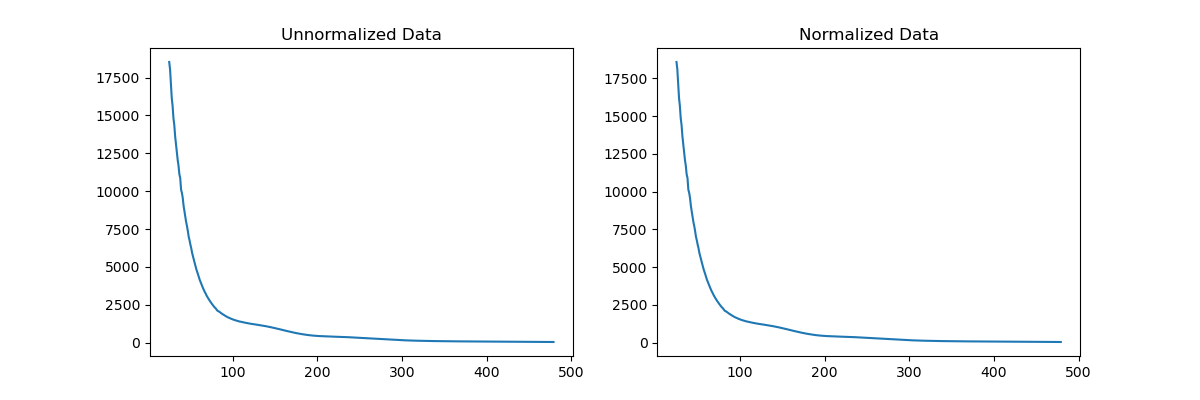

In [101]:
norm_data = normalize_to_baseline(azi_data) 

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(azi_data[0])
plt.title("Unnormalized Data")

plt.subplot(1,2,2)
plt.plot(norm_data[0])
plt.title("Normalized Data")
plt.show()

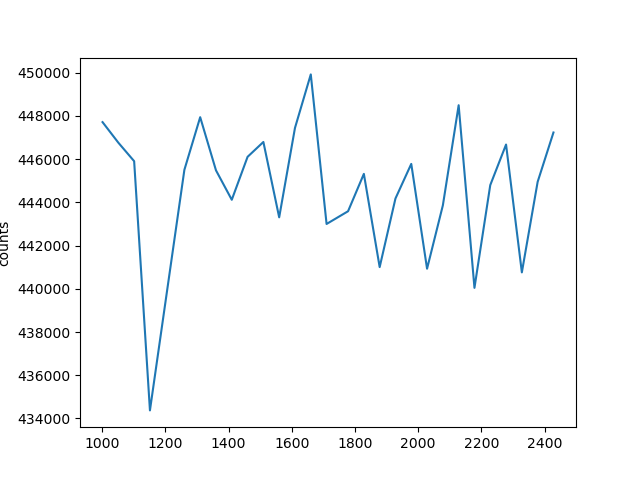

In [102]:
low_q = []
for i in range(len(norm_data)):
    q = np.sum(norm_data[i, 25:100])
    low_q.append(q)
    
low_q = np.array(low_q)

plt.figure()
plt.plot(image_number, low_q)
plt.ylabel("counts")
plt.show()

## Averaging Based on Delay Position

In [193]:
good_data.shape

(4870, 1024, 1024)

In [194]:
%%time
stage_len = len(uni_stage);               #  Number of delays
stage_ave = np.ones((stage_len,1024,1024)); #  Delay dependent averaged pp images
stage_ave_mk = np.ones((stage_len,1024,1024)); #  Delay dependent averaged pp images with mask

if stage_len>20:
    prt_count = 5
else:
    prt_count = 1  
for i in range(stage_len):
    if i%prt_count == 0:
        print('Averaging data at stage posi # '+ str(i) + ', ' + str(uni_stage[i]) + ' mm') # Obtain a sub array to save the data in one delay
    stage_data = good_data[np.where(good_stage==uni_stage[i])[0]];
    if bkg_sign == 'Yes':
        stage_ave[i] = np.nanmean(stage_data,axis=0) - bkg_dlys_ave; # subtracting the background
    else:
        stage_ave[i] = np.nanmean(stage_data,axis=0); # no subtracting background
    #stage_ave[i][stage_ave[i]<0] = 0; # make negative values to 0 
    


Averaging data at stage posi # 0, 206.6016 mm
Averaging data at stage posi # 5, 207.8007 mm
Averaging data at stage posi # 10, 208.0631 mm
Averaging data at stage posi # 15, 208.2504 mm
Averaging data at stage posi # 20, 208.4378 mm
Averaging data at stage posi # 25, 208.6252 mm
Averaging data at stage posi # 30, 208.8125 mm
Averaging data at stage posi # 35, 208.9999 mm
CPU times: user 9.26 s, sys: 4.53 s, total: 13.8 s
Wall time: 13.8 s


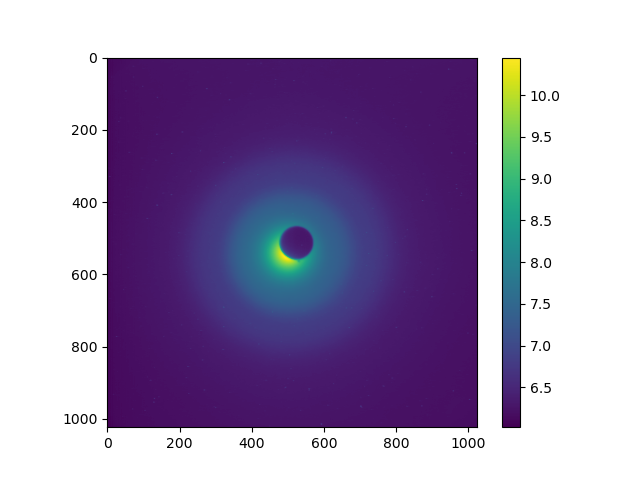

In [195]:
plt.figure()
plt.imshow(np.log(stage_ave[0]))
plt.colorbar()
plt.show()

## Generate Background Based on Corners -- After Averaging

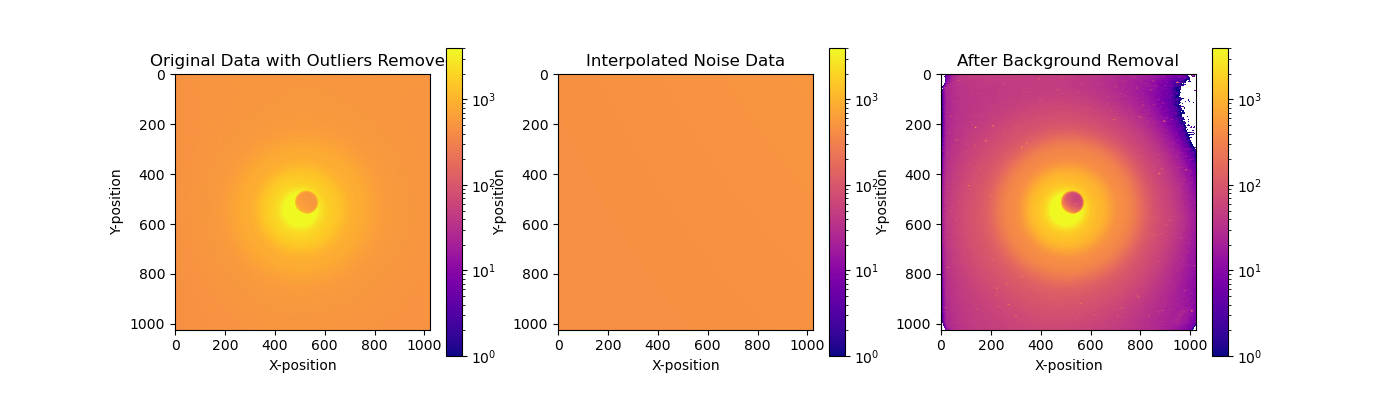

In [196]:
mean_data = np.mean(stage_ave, axis = 0)
std_data = np.std(stage_ave, axis = 0)

noise_data = backgroundNoise(mean_data)
noiseless_data = backgroundNoise(mean_data, remove_noise = True)

sub_edges = 'Yes'
if sub_edges =='Yes':
    stage_ave = stage_ave- noise_data
    good_counts = get_counts(stage_ave)

    
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
vmin_1_1, vmax_1_1 = 10**-0, 4000 

#Before
img1 = axes[0].imshow(mean_data, cmap='plasma', norm=matplotlib.colors.LogNorm(vmin=vmin_1_1, vmax=vmax_1_1))
axes[0].set_title('Original Data with Outliers Removed')
axes[0].set_xlabel('X-position')
axes[0].set_ylabel('Y-position')
colorbar1 = fig.colorbar(img1, ax=axes[0])  # Add colorbar to the first subplot

#Noise
img2 = axes[1].imshow(noise_data, cmap='plasma',  norm=matplotlib.colors.LogNorm(vmin=vmin_1_1, vmax=vmax_1_1))  
# Use the same normalization as img1
axes[1].set_title('Interpolated Noise Data')
axes[1].set_xlabel('X-position')
axes[1].set_ylabel('Y-position')
colorbar2 = fig.colorbar(img2, ax=axes[1])  # Add colorbar to the second subplot

# Noise Removed
img3 = axes[2].imshow(noiseless_data, cmap='plasma',  norm=matplotlib.colors.LogNorm(vmin=vmin_1_1, vmax=vmax_1_1))  # Logarithmic scaling
axes[2].set_title('After Background Removal')
axes[2].set_xlabel('X-position')
axes[2].set_ylabel('Y-position')
colorbar3 = fig.colorbar(img3, ax=axes[2])  # Add colorbar to the third subplot


# img4 = axes[3].plot(good_counts, '-d')
# axes[3].set_xlabel('Image Number');
# axes[3].set_ylabel('Counts');



## Masking Beam Block -- After Averaging

### Find Mask Location

In [197]:
# (1) Hole mask: Define mask of the hole
data_ave_raw = np.mean(stage_ave,axis=0); # Mean data of all the images
data_ave     = np.copy(data_ave_raw) #[200:900,200:900]
image_array  = np.log(data_ave)/np.nanmax(np.log(data_ave))
image_array  *=255
im = Image.fromarray(image_array)
im = im.convert('L')
im = np.array(im)

# Mask hole and Finding the diffraction center
hole = np.squeeze(cv2.HoughCircles(im, cv2.HOUGH_GRADIENT_ALT, 1.5, 32, param1=50, param2=0.9, minRadius=30, maxRadius=60))
mask = np.ones((1024,1024)) # Hole mask
y_m,x_m = np.ogrid[:1024,:1024];
mask[((x_m-hole[0])**2 + (y_m-hole[1])**2 <= (hole[2]+5)**2)] = np.nan;# Create a circular mask filled with nans inside the circle
print('The hole center at ' + str(hole[0:2]) + ' with radius ' + str(hole[2:3]));
#stage_ave = stage_ave*mask
#good_data = good_data*mask

The hole center at [526.5 513. ] with radius [45.818153]


/tmp/ipykernel_4068204/1122712592.py:4: RuntimeWarning: invalid value encountered in log
  image_array  = np.log(data_ave)/np.nanmax(np.log(data_ave))


In [198]:
#hole_center = (477.0, 465.0)
hole_center = hole[0], hole[1]
print(hole_center)
inner_radius = float(hole[2])
outer_radius = 575
data_ave_raw = np.mean(stage_ave,axis=0); 
ring_mask_data = detectorMask(stage_ave, hole_center, inner_radius, outer_radius, plot_image = True)
ring_mask_ave = np.mean(ring_mask_data, axis = 0)
print(ring_mask_data.shape)

(526.5, 513.0)
(39, 1024, 1024)


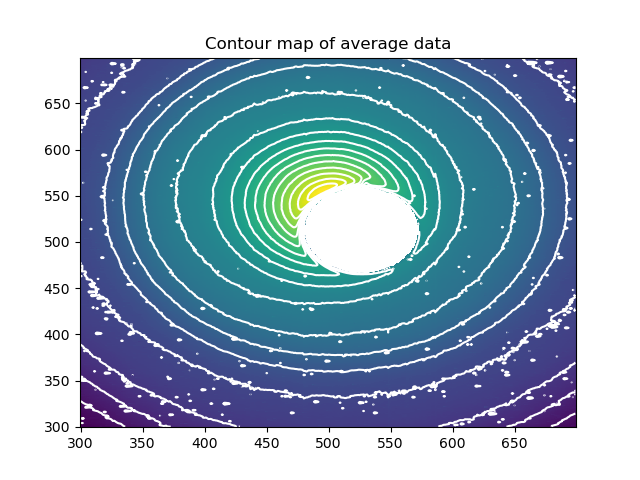

In [199]:
import matplotlib.cm as cm
x = np.arange(300, 700)
y = np.arange(300, 700)
X, Y = np.meshgrid(y, x)
fig, ax= plt.subplots()
ax.pcolormesh(x, y, np.log(ring_mask_ave[300:700, 300:700]))
CS = ax.contour(X, Y, np.log(ring_mask_ave[300:700, 300:700]), levels = 20, colors='w')
ax.set_title('Contour map of average data')

stage_ave = ring_mask_data

## Finding Diffraction Center -- After Averaging

Right now it is only worthwhile to run this on the stage averaged data as it takes a very long time. Ultimately will try to get working in parallel in order to find the center of each individual image. __Note:__ occasionally it returns a 0, 0 value for the centers. The average of all non-zero values are taken and then each zero is replaced with the average center. Test this vs lab time.

In [200]:
stage_ave.shape

(39, 1024, 1024)

In [201]:
%%time

x_centers = []
y_centers = []
for i in range(len(stage_ave)):
    center = find_beam_center(stage_ave[i],center=[500,500],r=200)
    x_centers.append(center[0])
    y_centers.append(center[1])
    if i%1 == 0:
        print('Found center of ' + str(center)+' stage_position ' + str(uni_stage[i]))
x_centers = np.array(x_centers)
y_centers = np.array(y_centers)
centers = x_centers, y_centers
x_ave = np.mean(x_centers[np.where(x_centers > 0)[0]])
y_ave = np.mean(y_centers[np.where(y_centers > 0)[0]])
x_centers[np.where(x_centers == 0)[0]] = x_ave
y_centers[np.where(y_centers == 0)[0]] = y_ave
center_ave = x_ave, y_ave
print(r'Averaged ctr is ' + str(center_ave))

Found center of [542.8238849993774, 505.32586238883204] stage_position 206.6016
Found center of [542.9627759066299, 504.7791218043605] stage_position 207.351
Found center of [543.2195281195603, 505.70494230229576] stage_position 207.5009
Found center of [542.7706020340149, 505.0387535917802] stage_position 207.6508
Found center of [541.9125473809238, 505.5491953034569] stage_position 207.7258
Found center of [543.0926852331768, 505.5596272732424] stage_position 207.8007
Found center of [542.566722987043, 504.8818750578606] stage_position 207.8757
Found center of [543.1935268434395, 506.25591788345275] stage_position 207.9506
Found center of [542.8382091677948, 506.6859215040214] stage_position 207.9881
Found center of [543.0414755024925, 506.34080973732443] stage_position 208.0256
Found center of [542.8487178370045, 505.8088178083585] stage_position 208.0631
Found center of [543.4516876579603, 505.63631831072144] stage_position 208.1005
Found center of [542.4883939169381, 506.211632326

/tmp/ipykernel_4068204/1299543132.py:7: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(np.mean(stage_ave, axis=0)));


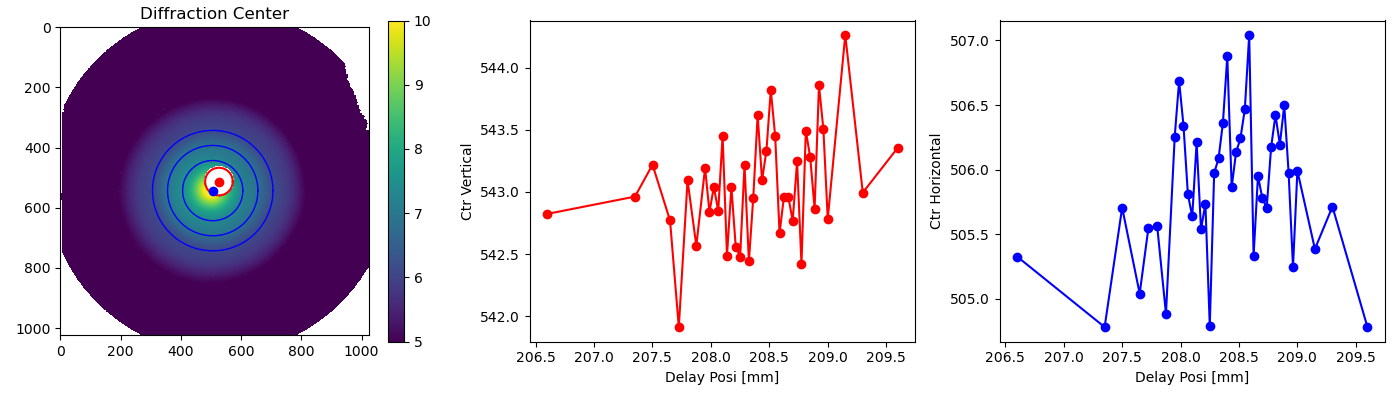

In [202]:
theta = np.linspace(0, 2 * np.pi, 200)
x = np.cos(theta)*hole[2]+hole[0];
y = np.sin(theta)*hole[2]+hole[1];
plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
plt.imshow(np.log(np.mean(stage_ave, axis=0)));
plt.colorbar()
plt.plot(x,y,'r',hole[0],hole[1],'or',center_ave[1],center_ave[0],'ob');
for i in range(3):
    x = np.cos(theta)*(i+2)*50+center_ave[1];
    y = np.sin(theta)*(i+2)*50+center_ave[0];
    plt.plot(x,y,linewidth=1,color='b');
plt.clim([5,10]);
plt.title('Diffraction Center')

plt.subplot(1,3,2)
plt.plot(uni_stage, centers[0],'-or');
plt.xlabel('Delay Posi [mm]');
plt.ylabel('Ctr Vertical');

plt.subplot(1,3,3)
plt.plot(uni_stage, centers[1],'-ob');
plt.xlabel('Delay Posi [mm]');
plt.ylabel('Ctr Horizontal');

plt.tight_layout()
plt.show();

## Clean After Averaging

Here, we utilize a masked array to create nan values for each entry outside of the standard deviation threshold. In this way, we eliminate the need for inputting NaN values, as these are stored as a Boolean.

In [164]:
%%time

#clean_data = cleanMean(test_data)
#counts_clean = get_counts(clean_data)
clean_data = clean_and_filter(stage_ave)
clean_data = np.array(clean_data)
counts_clean = get_counts(clean_data)

counts_clean_mean = np.mean(counts_clean)
counts_clean_std = np.std(counts_clean)

Cleaning data
CPU times: user 6.91 s, sys: 157 ms, total: 7.06 s
Wall time: 7.08 s


/tmp/ipykernel_4068204/1136715142.py:23: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(clean_data[0]));


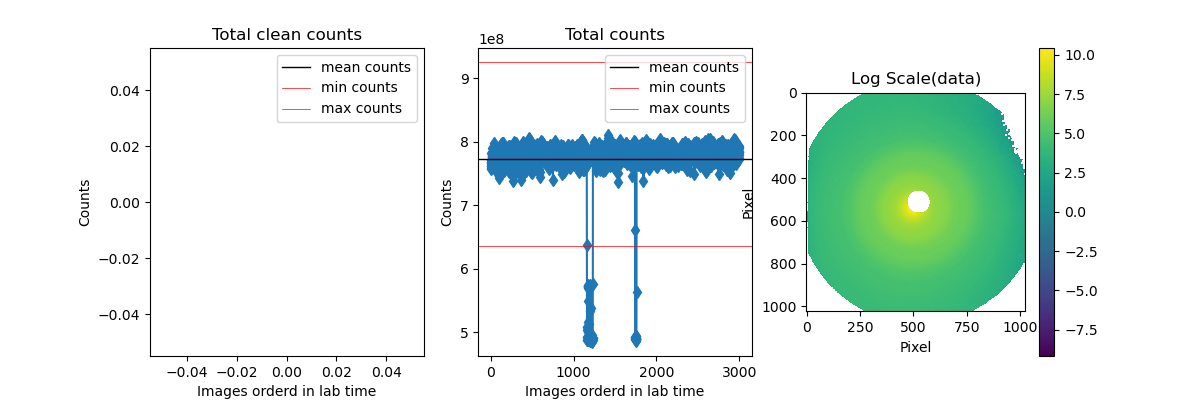

In [145]:
fig = plt.figure(figsize = (12,4))
plt.subplot(1, 3, 1)
plt.plot(counts_clean,'-d')
plt.axhline(y = counts_clean_mean, color = 'k', linestyle = '-',linewidth=1, label="mean counts");
plt.axhline(y = counts_clean_mean-(3*counts_clean_std), color = 'r', linestyle = '-',linewidth=0.5, label="min counts");
plt.axhline(y = counts_clean_mean+(3*counts_clean_std), color = 'r', linestyle = '-',linewidth=0.5, label="max counts");
plt.xlabel('Images orderd in lab time');
plt.ylabel('Counts');
plt.legend()
plt.title('Total clean counts');

plt.subplot(1, 3, 2)
plt.plot(counts,'-d')
plt.axhline(y = np.mean(counts), color = 'k', linestyle = '-',linewidth=1, label="mean counts");
plt.axhline(y = counts_mean-(3*np.std(counts)), color = 'r', linestyle = '-',linewidth=0.5, label="min counts");
plt.axhline(y = counts_mean+(3*np.std(counts)), color = 'r', linestyle = '-',linewidth=0.5, label="max counts");
plt.xlabel('Images orderd in lab time');
plt.ylabel('Counts');
plt.legend()
plt.title('Total counts')

plt.subplot(1, 3, 3)
plt.imshow(np.log(clean_data[0]));
plt.colorbar()
plt.xlabel('Pixel');
plt.ylabel('Pixel');
plt.title('Log Scale(data)')

plt.show()

## Removing Radial Outliers -- BETA (WORKS! but slow)

Runs the function `remove_radial_outliers` which takes in a 1024, 1024 image and generates the radial average of that image. Then it compares each point at that radial distance with the mean to a threshhold value of 3 standard deviations from the mean. If the pixel value falls outside of the threshhold range, the average radial value is swapped in. 

__Notes:__ 
 - Requires global variables of `X_CENTER`, `Y_CENTER`, and `GRID_SIZE` 
 - Currently runs very slowly. Will work on running it in parallel eventually
 - Try starting radial values at 1 instead of zero to remove runtime warning
 - Need to add additional mask eventually as this exaggerates bright spot in the data

In [214]:
%%time
stage_ave = np.nan_to_num(stage_ave)
X_CENTER = center_ave[0]
Y_CENTER = center_ave[1]
GRID_SIZE = 1024
# azi_data = []
# for image in stage_ave:
#     data, _ = get_radial_distribution(image) # Function of averaging
#     azi_data.append(data)
    
    
# azi_data = np.array(azi_data)
# print(azi_data.shape)

cleaned_data = []
for image in stage_ave:
    clean_image = remove_radial_outliers(image)
    cleaned_data.append(clean_image)

cleaned_data = np.array(cleaned_data)


CPU times: user 3min 3s, sys: 2.65 s, total: 3min 5s
Wall time: 3min 6s


/tmp/ipykernel_2772609/277139372.py:6: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(stage_ave[0]))
/tmp/ipykernel_2772609/277139372.py:6: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(stage_ave[0]))
/tmp/ipykernel_2772609/277139372.py:10: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(cleaned_data[0]))


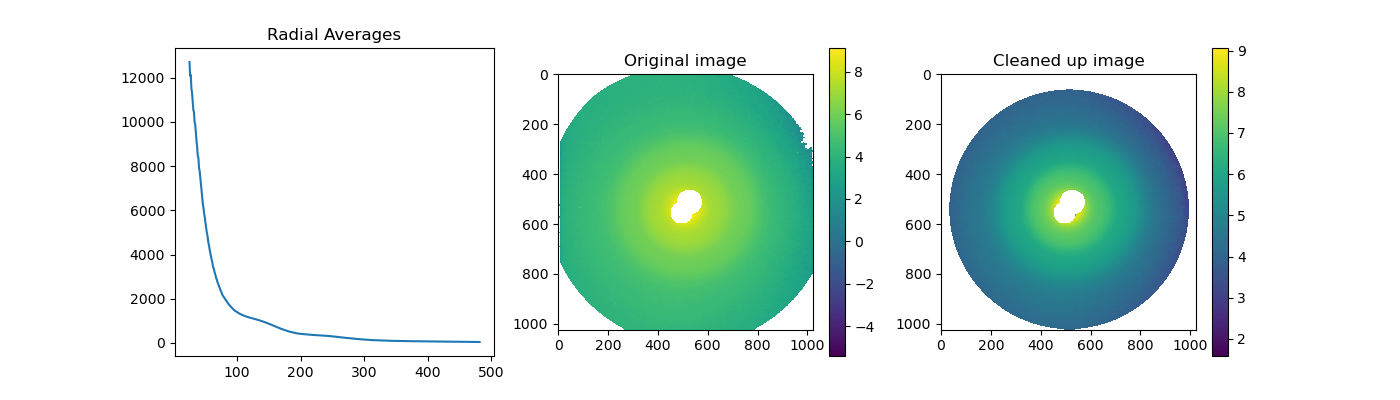

In [215]:
plt.figure(figsize=(14,4))
plt.subplot(1, 3, 1)
plt.plot(azi_data[0])
plt.title("Radial Averages")
plt.subplot(1, 3, 2)
plt.imshow(np.log(stage_ave[0]))
plt.colorbar()
plt.title("Original image")
plt.subplot(1,3,3)
plt.imshow(np.log(cleaned_data[0]))
plt.colorbar()
plt.title("Cleaned up image")
plt.show()

stage_ave = cleaned_data
del cleaned_data

## Azimuthal Averaging -- SLAC Way

In [203]:
X_CENTER = center_ave[0]
Y_CENTER = center_ave[1]
#X_CENTER = 539
#Y_CENTER = 505
GRID_SIZE = 1024

pointer = np.empty((1024,1024))
for i in range(GRID_SIZE):
    for j in range(GRID_SIZE):
        pointer[i,j]=int(np.sqrt((i-X_CENTER)**2+(j-Y_CENTER)**2))
img_r_max = int(min(X_CENTER, Y_CENTER, GRID_SIZE-X_CENTER, GRID_SIZE-Y_CENTER))
x=[];y=[]
for ri in range(img_r_max):
    [X_temp,Y_temp]=np.where(pointer==ri)
    x.append(X_temp)
    y.append(Y_temp)
print(r'max Q index is ' + str(img_r_max));
r_max=len(x)

azi_data = get_azimuthal_average(stage_ave, x, y)

max Q index is 480


/tmp/ipykernel_4068204/1622898995.py:62: RuntimeWarning: Mean of empty slice
  ave=np.nanmean(I_r)
/tmp/ipykernel_4068204/1622898995.py:65: RuntimeWarning: Mean of empty slice
  I[ri]=np.nanmean(I_r)


## Normalize Azimuthal Averages to Baseline

/tmp/ipykernel_4068204/1491087645.py:242: RuntimeWarning: Mean of empty slice
  data_mean = np.nanmean(data, axis=0)


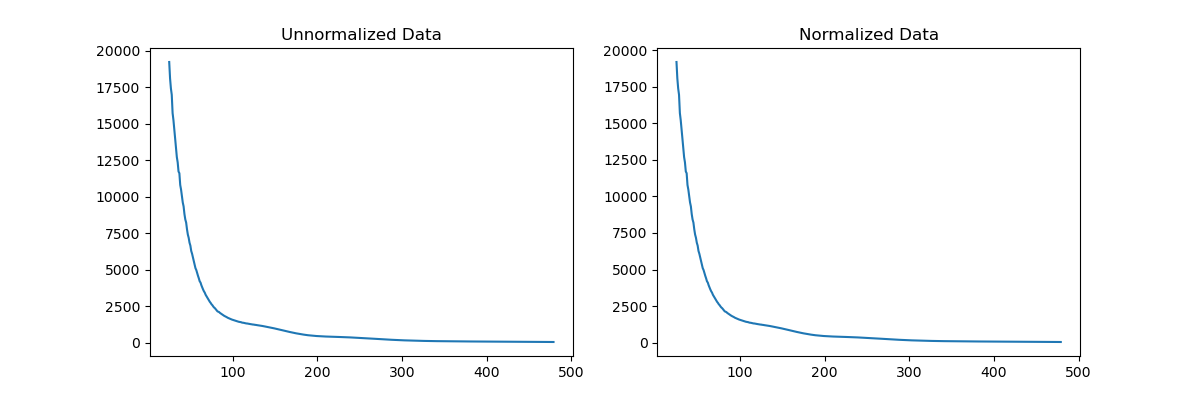

In [204]:
norm_data = normalize_to_baseline(azi_data) 

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(azi_data[0])
plt.title("Unnormalized Data")

plt.subplot(1,2,2)
plt.plot(norm_data[0])
plt.title("Normalized Data")
plt.show()

## Plotting the Time-Dependent Signal

/tmp/ipykernel_4068204/1791173887.py:15: RuntimeWarning: Mean of empty slice
  norm_ref = np.nanmean(norm_data[-N_ref:], axis=0)


26


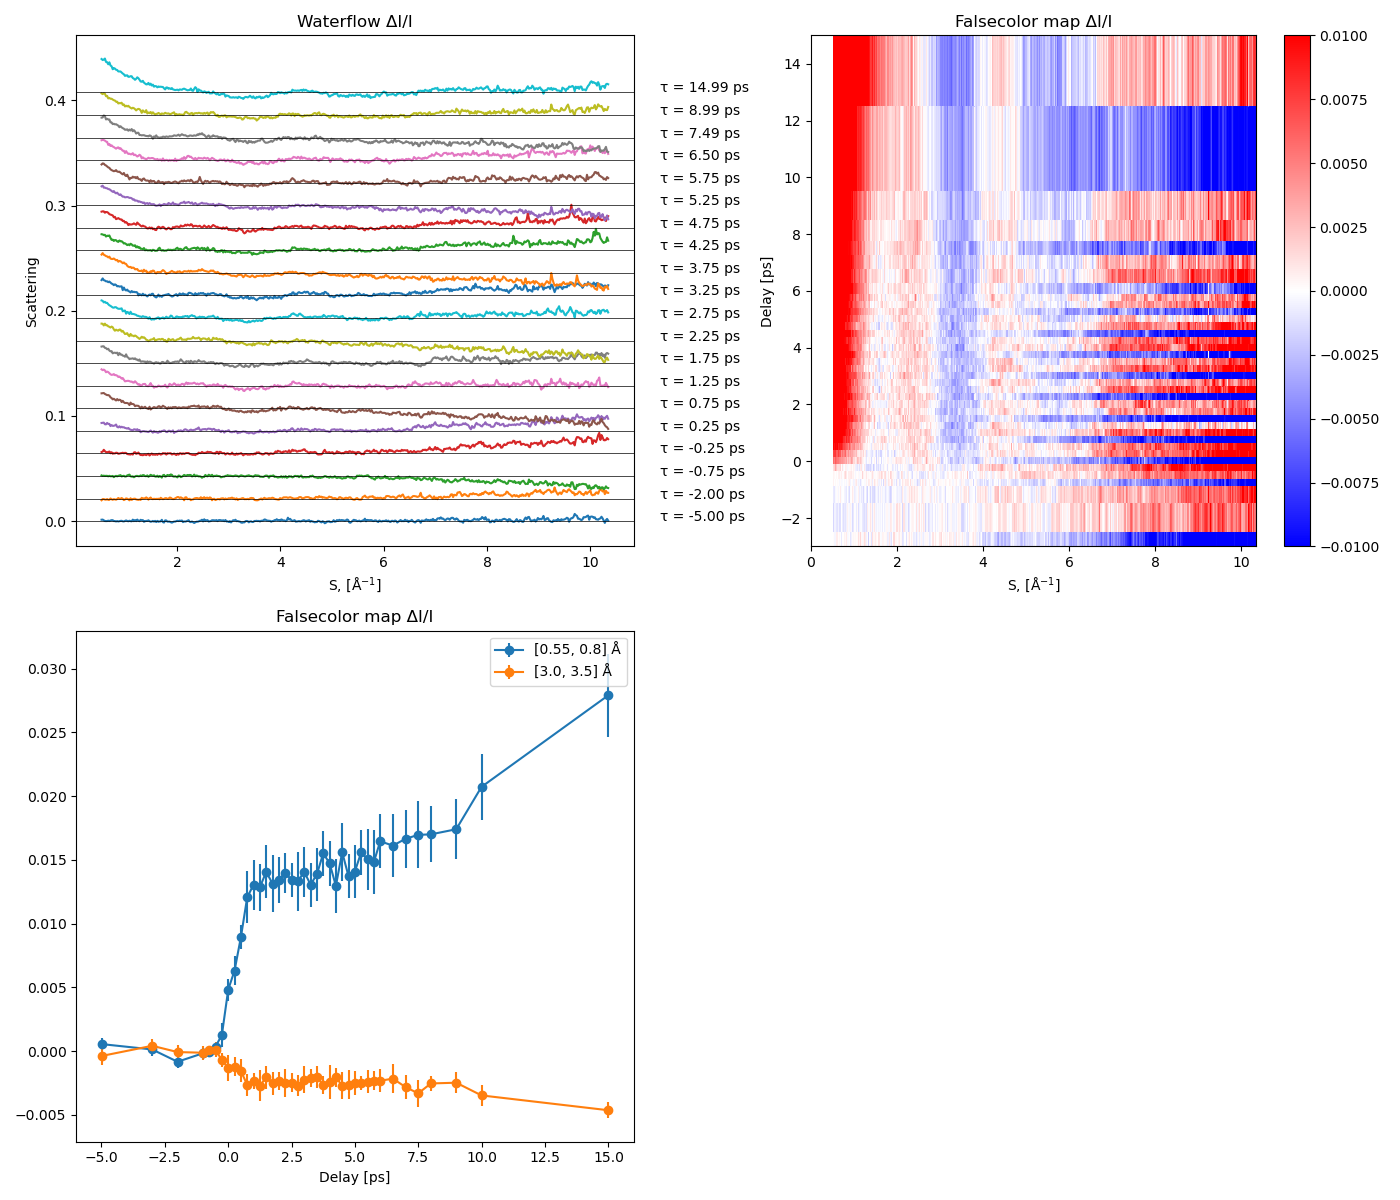

In [264]:
# (3) Plot the figure: Plot the time-dependent signal
angs = '\u00C5'; # angstrom sign
s_cali = 0.0216 # S calibration in experiment
#posi_0    = 154.405 # The reference T0
posi_0 = 208.85
s = np.arange(0,len(azi_data[0]))*s_cali # The Q axis
realtime = -(uni_stage-posi_0)/0.15  # Delay axis in ps

if stage_len<5: # Make up the reference signals
    N_ref = 2
else:
    N_ref = 6

#norm_ref = np.nanmean(norm_data[:N_ref],axis=0);         # Reference signal before T0
norm_ref = np.nanmean(norm_data[-N_ref:], axis=0)
dI_I_norm = (norm_data-norm_ref)/norm_ref; # Calculate the percentage difference signal

# Plot a figure of the time-depdendent signal of scattering percentage difference.
plt.figure(figsize=(14,12))

plt.subplot(2,2,1)
for i in range(stage_len):
    if i%2 == 0:
        plt.plot(s,dI_I_norm[stage_len-i-1] + np.nanmax(dI_I_norm)*(i)/3);
        plt.text(s[-1]+1,np.nanmax(dI_I_norm)*(i)/3, r'τ = {0:.2f} ps'.format(realtime[stage_len-i-1]))
        plt.axhline(y = np.nanmax(dI_I_norm)*(i)/3, color = 'k', linestyle = '-',linewidth=0.5);
plt.xlabel(r'S, ['+angs+'$^{-1}$]');plt.ylabel('Scattering');plt.title('Waterflow ΔI/I');

plt.subplot(2,2,2)
plt.pcolor(s,realtime,dI_I_norm,cmap='bwr');
plt.clim(vmin=-0.01, vmax=0.01);
plt.colorbar()
#plt.xlim(0.5, 5)
plt.ylim(-3, 15)
plt.xlabel(r'S, ['+angs+'$^{-1}$]');plt.ylabel('Delay [ps]');plt.title('Falsecolor map ΔI/I')

plt.subplot(2,2,3)
RoI_1 = [0.55, 0.8];
RoI_2 = [3.0, 3.5];
print(round(RoI_1[0]/0.0215))
Inte_1 = dI_I_norm[:,round(RoI_1[0]/s_cali):round(RoI_1[1]/s_cali)].mean(axis=1);
std_1 = dI_I_norm[:,round(RoI_1[0]/s_cali):round(RoI_1[1]/s_cali)].std(axis=1);
Inte_2 = dI_I_norm[:,round(RoI_2[0]/s_cali):round(RoI_2[1]/s_cali)].mean(axis=1);
std_2 = dI_I_norm[:,round(RoI_2[0]/s_cali):round(RoI_2[1]/s_cali)].std(axis=1);
#plt.errorbar(realtime,Inte_1,'-*', yerr=std_1, linewidth=3, label=str(RoI_1)+' '+angs);
#plt.errorbar(realtime,Inte_2,'-*', yerr=std_2, linewidth=3, label=str(RoI_2)+' '+angs);
plt.errorbar(realtime,Inte_1, yerr=std_1,  fmt='-o',  label=str(RoI_1)+' '+angs);
plt.errorbar(realtime,Inte_2, yerr=std_2,  fmt='-o', label=str(RoI_2)+' '+angs);
#plt.errorbar(realtime,Inte_3, yerr=std_3,  fmt='-o', label=str(RoI_2)+' '+angs);
plt.legend()
plt.xlabel('Integrated Yield [arb.]');plt.xlabel('Delay [ps]');plt.title('Falsecolor map ΔI/I')

plt.tight_layout()
plt.show()

# plt.tight_layout()
# plt.show()

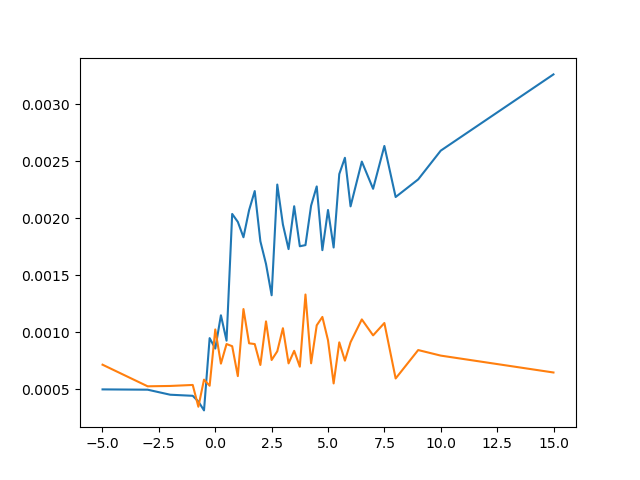

In [206]:
plt.figure()
plt.plot(realtime, std_1)
plt.plot(realtime, std_2)
plt.show()

## Power Fitting

In [94]:
dI_I_norm[:, -50:].shape

(38, 50)

In [253]:

corrected_dI, baseline2d = power_fit(dI_I_norm, s, degree = 2, return_baseline=True)
dI_I_ave = np.nanmean(dI_I_norm, axis=0)
corrected_ave = np.nanmean(corrected_dI, axis=0)
baseline_ave = np.nanmean(baseline2d, axis=0)

/tmp/ipykernel_4068204/1051190957.py:2: RuntimeWarning: Mean of empty slice
  dI_I_ave = np.nanmean(dI_I_norm, axis=0)
/tmp/ipykernel_4068204/1051190957.py:3: RuntimeWarning: Mean of empty slice
  corrected_ave = np.nanmean(corrected_dI, axis=0)


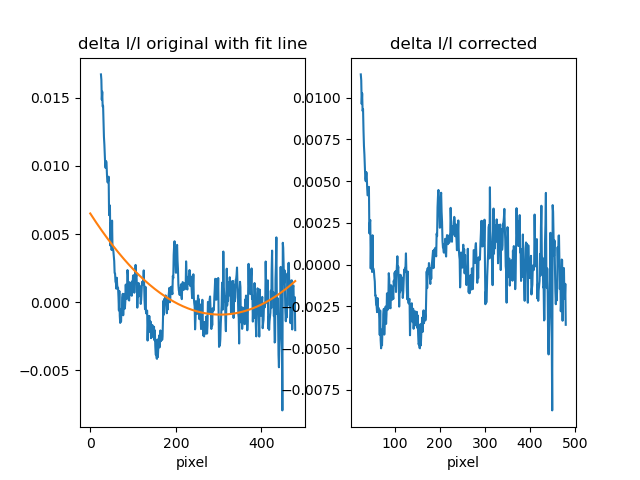

In [254]:
plt.figure()
plt.subplot(1,2,1)
plt.plot(dI_I_norm[20])
plt.plot(baseline2d[20])
plt.xlabel("pixel")
plt.title("delta I/I original with fit line")

plt.subplot(1,2,2)
plt.plot(corrected_dI[20])
plt.xlabel("pixel")
plt.title("delta I/I corrected")
plt.show()

In [265]:
s_range = np.arange(200, 480, 1)
corrected_dI, baseline2d = fit_high_s(dI_I_norm, s, s_range, return_baseline=True)
dI_I_ave = np.nanmean(dI_I_norm, axis=0)
corrected_ave = np.nanmean(corrected_dI, axis=0)
baseline_ave = np.nanmean(baseline2d, axis=0)

/tmp/ipykernel_4068204/3087473166.py:3: RuntimeWarning: Mean of empty slice
  dI_I_ave = np.nanmean(dI_I_norm, axis=0)
/tmp/ipykernel_4068204/3087473166.py:4: RuntimeWarning: Mean of empty slice
  corrected_ave = np.nanmean(corrected_dI, axis=0)


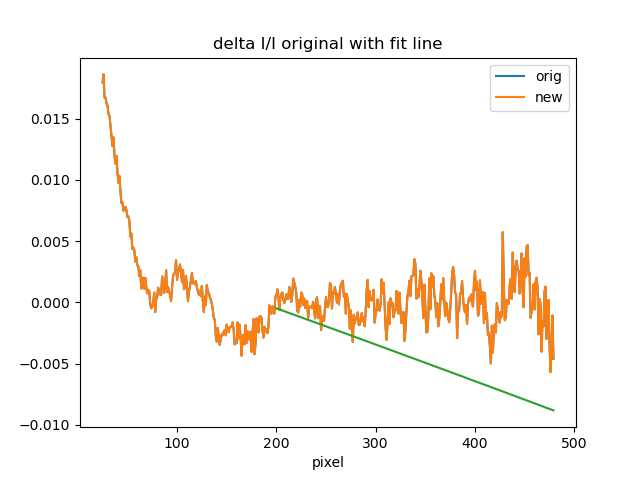

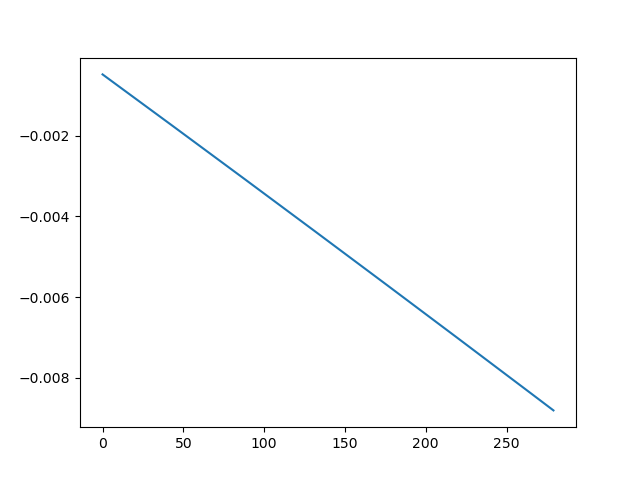

In [266]:
plt.figure()
plt.plot(dI_I_norm[10], label="orig")
plt.plot(corrected_dI[10], label="new")
plt.plot(s_range, baseline2d[10])
plt.legend()
#plt.plot(baseline2d[20])
plt.xlabel("pixel")
plt.title("delta I/I original with fit line")

plt.show()

plt.figure()
plt.plot(baseline2d[10])
plt.show()

### Plot with Error Bars

In [267]:
print(corrected_dI.shape)
print(s.shape)
print(uni_stage)

(39, 480)
(480,)
[206.6016 207.351  207.5009 207.6508 207.7258 207.8007 207.8757 207.9506
 207.9881 208.0256 208.0631 208.1005 208.138  208.1755 208.2129 208.2504
 208.2879 208.3254 208.3628 208.4003 208.4378 208.4753 208.5127 208.5502
 208.5877 208.6252 208.6626 208.7001 208.7376 208.7751 208.8125 208.85
 208.8875 208.9249 208.9624 208.9999 209.1498 209.2997 209.5995]


25


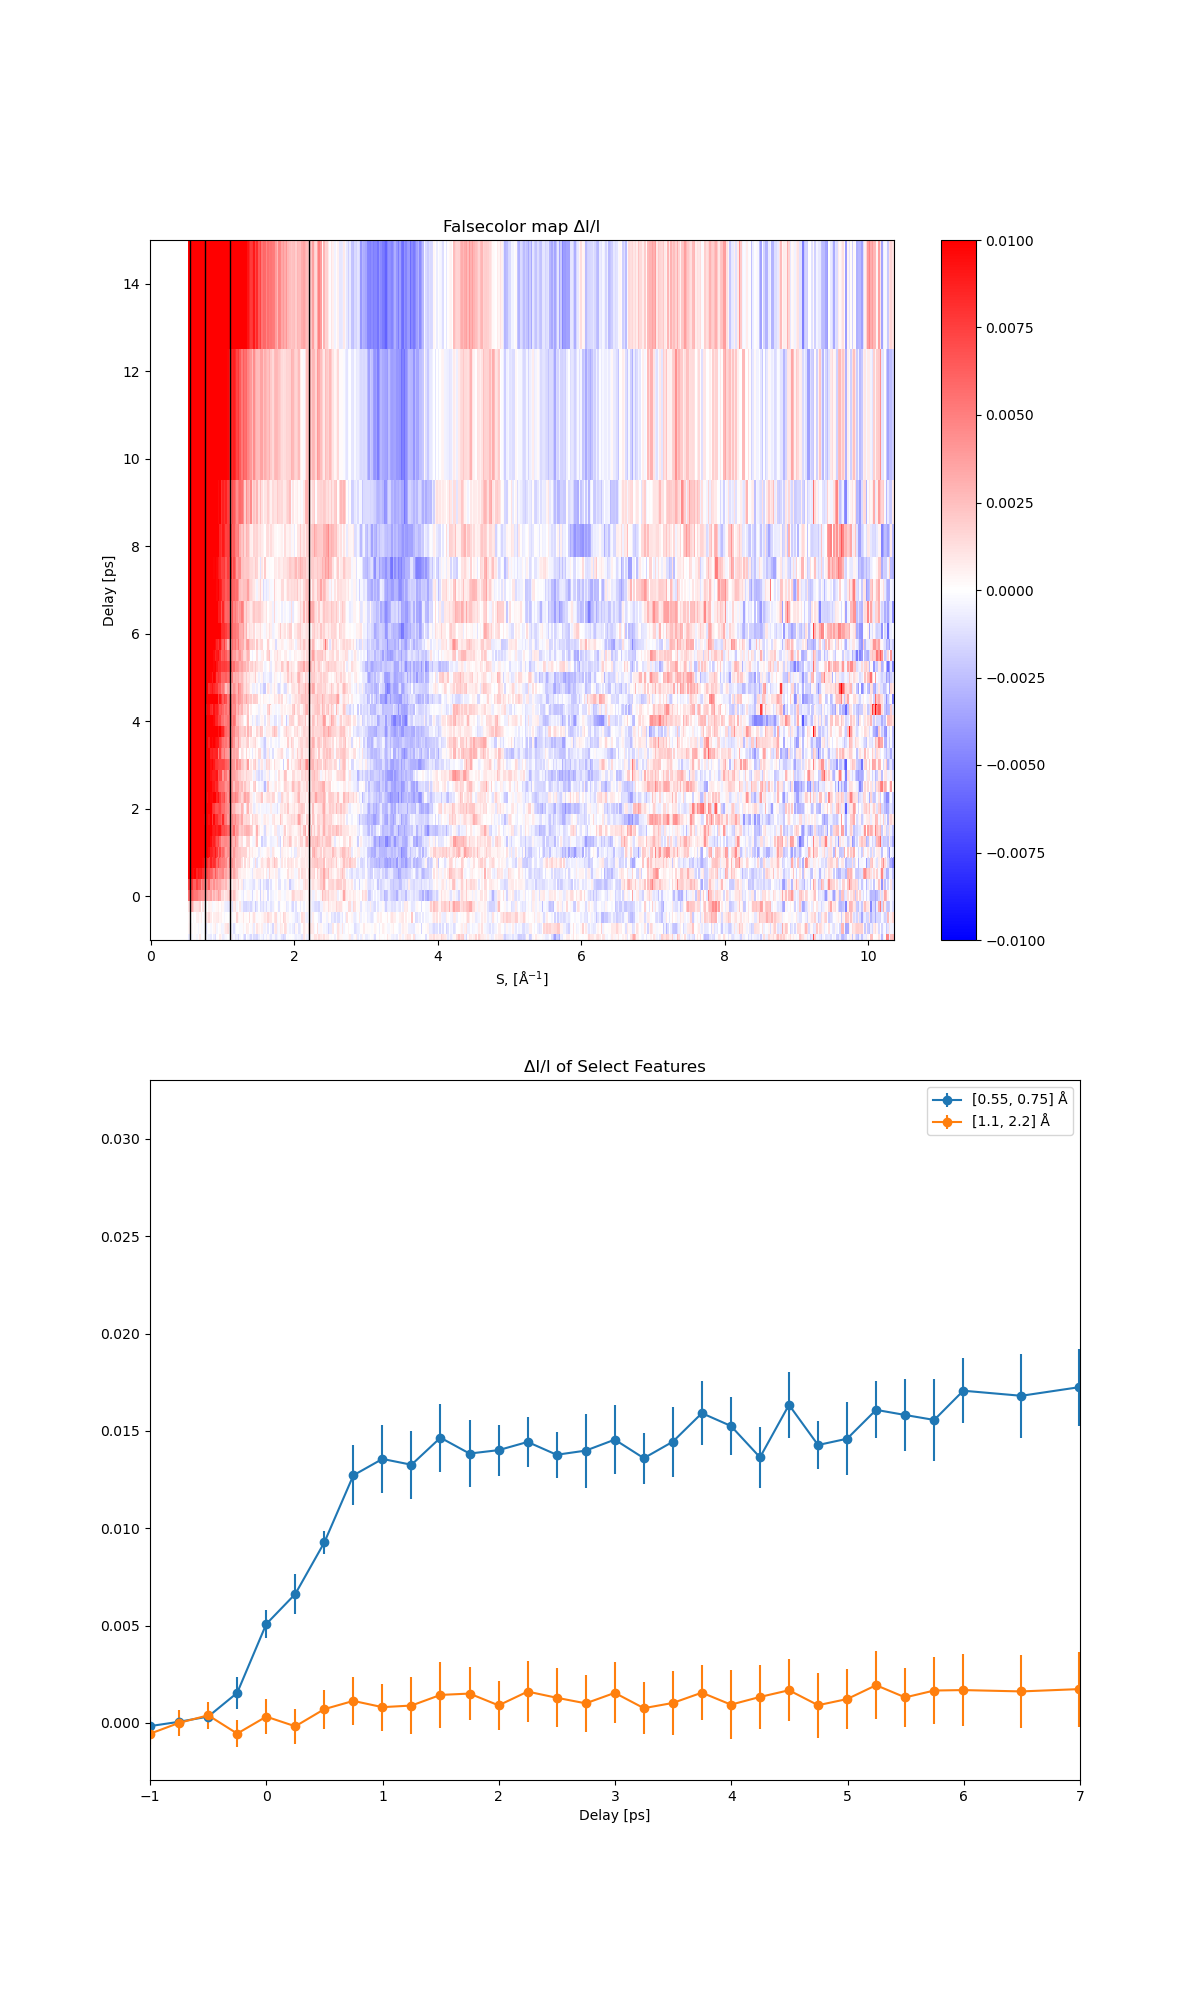

In [269]:
RoI_1 = [0.55, 0.75];
RoI_2 = [1.1, 2.2];
RoI_3 = [2.0, 2.6];
print(round(RoI_1[0]/s_cali))
Inte_1 = corrected_dI[:,round(RoI_1[0]/s_cali):round(RoI_1[1]/s_cali)].mean(axis=1);
std_1 = corrected_dI[:,round(RoI_1[0]/s_cali):round(RoI_1[1]/s_cali)].std(axis=1)
Inte_2 = corrected_dI[:,round(RoI_2[0]/s_cali):round(RoI_2[1]/s_cali)].mean(axis=1);
std_2 = corrected_dI[:,round(RoI_2[0]/s_cali):round(RoI_2[1]/s_cali)].std(axis=1);
Inte_3 = corrected_dI[:,round(RoI_3[0]/s_cali):round(RoI_3[1]/s_cali)].mean(axis=1);
std_3 = corrected_dI[:,round(RoI_3[0]/s_cali):round(RoI_3[1]/s_cali)].std(axis=1);

plt.figure(figsize=(12,20))
plt.subplot(2,1,1)
plt.pcolor(s,realtime,corrected_dI,cmap='bwr');
plt.axvline(x = RoI_1[0], color = 'k', linestyle = '-',linewidth=1);
plt.axvline(x = RoI_1[1], color = 'k', linestyle = '-',linewidth=1);
plt.axvline(x = RoI_2[0], color = 'k', linestyle = '-',linewidth=1);
plt.axvline(x = RoI_2[1], color = 'k', linestyle = '-',linewidth=1);
# plt.axvline(x = RoI_3[0], color = 'k', linestyle = '-',linewidth=1);
# plt.axvline(x = RoI_3[1], color = 'k', linestyle = '-',linewidth=1);
plt.clim(vmin=-0.01, vmax=0.01);
plt.colorbar()
plt.ylim(-1, 15)
#plt.ylim(154.35, 154.6)
#plt.xlim(0.2,10)
plt.xlabel(r'S, ['+angs+'$^{-1}$]');plt.ylabel('Delay [ps]');
plt.title('Falsecolor map ΔI/I')

plt.subplot(2,1,2)
#plt.errorbar(realtime,Inte_1,'-*', yerr=std_1, linewidth=3, label=str(RoI_1)+' '+angs);
#plt.errorbar(realtime,Inte_2,'-*', yerr=std_2, linewidth=3, label=str(RoI_2)+' '+angs);
plt.errorbar(realtime,Inte_1, yerr=std_1,  fmt='-o',  label=str(RoI_1)+' '+angs);
plt.errorbar(realtime,Inte_2, yerr=std_2,  fmt='-o', label=str(RoI_2)+' '+angs);
#plt.errorbar(realtime,Inte_3, yerr=std_3,  fmt='-o', label=str(RoI_2)+' '+angs);
plt.xlim(-1, 7)
plt.legend()
plt.xlabel('Integrated Yield [arb.]');plt.xlabel('Delay [ps]');plt.title('ΔI/I of Select Features')

plt.show()

## Fitting Rise Time

Uses a selected feature in the data to calculate a rise time based on the `scipy.special.erf()`

/tmp/ipykernel_4068204/1255863019.py:9: RuntimeWarning: Mean of empty slice
  latedata = np.nanmean(corrected_dI[2:15], axis=0)


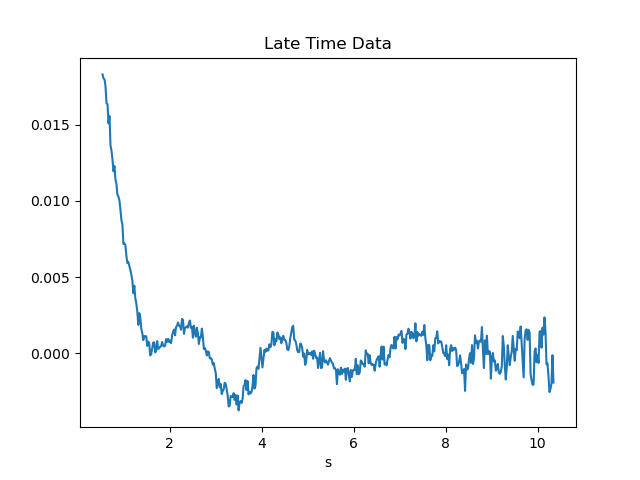

In [263]:
time1 =realtime
t0_1= Inte_1
# t0_2 = Inte_2
data1 = corrected_dI
# s1 = s
# raw_data1 = good_data
# time1.shape

latedata = np.nanmean(corrected_dI[2:15], axis=0)
plt.figure()
plt.plot(s, latedata)
plt.title("Late Time Data")
plt.xlabel("s")
plt.show()

In [145]:
realtime[-15:]

array([ 1.39933333,  1.19933333,  0.99933333,  0.79933333,  0.59933333,
        0.4       ,  0.2       , -0.        , -0.2       , -0.4       ,
       -0.59933333, -0.79933333, -0.99933333, -4.99666667, -9.99333333])

Fit parameters: 
t_0 = 0.2241  ps +-  0.0514  ps
FWHM =  1.0781 ps 0.1627 ps




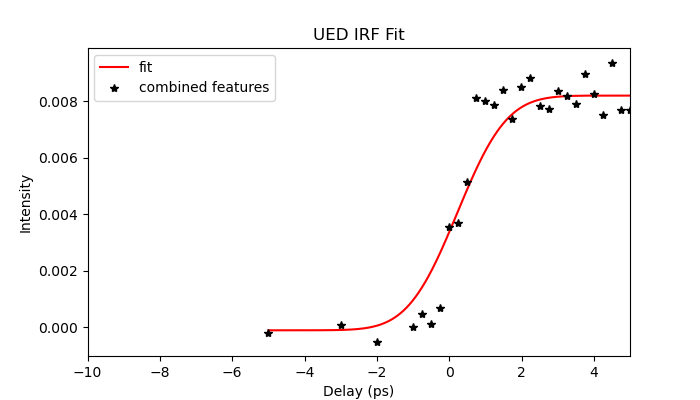

In [78]:
#Optimise

A = 0.04
t0 = 0.0
sigma = 0.5
offset = 0.1
x0 = [A, t0, sigma,offset]
# ## when fitting with an error function
import scipy
def equations(t, A, t0, sigma, offset): #def equations
    fit = A*(scipy.special.erf((t-t0)/(np.sqrt(2)*sigma)))+offset
    return fit

def erf_fit(t, A, t0, sigma, offset):
    fit = A* scipy.special.erf(((t-t0)/(sigma/(np.sqrt(2*np.log(2)))))*np.sqrt(2))+offset
    return fit 

# yo = equations(t, A, t0, sigma, offset) #equations
popt, pcov, id, _, _ = curve_fit(erf_fit, time1[:], t0_1[:], p0 = x0, maxfev = 5000000, method='lm',full_output=True)
t_new = np.linspace(realtime[0],realtime[-1],1000)
## error func fit
A, t0, sigma, offset = popt
print("Fit parameters: ")
print("=====================================================")

print("t_0 =", '%1.4f '%(popt[1]),'ps +- ','%1.4f '%np.sqrt(pcov[1,1]),"ps")
print("FWHM = ", '%1.4f'%(popt[2]), 'ps', '%1.4f' %np.sqrt(pcov[2,2]), "ps")

print("\n")
y_new = equations(t_new, *popt)
plt.figure(figsize=(7,4))
# plt.plot(t,yo,color=‘purple’,ls=‘--’)
plt.plot(t_new,y_new,color='red', label="fit")
plt.plot(time1, t0_1,'*',color='black', label="combined features")
plt.xlim(-10,5)
#plt.ylim(-0.005, .01)
plt.xlabel("Delay (ps)")
plt.ylabel("Intensity")
plt.title("UED IRF Fit")
plt.legend()
plt.show()

## Save Data 

In [270]:
# np.savetxt("data_files/dI_s4_3000-4000_12-05-2023.txt", corrected)
# np.savetxt("data_files/s_s4_3000-4000_12-05-2023.txt", s)
# np.savetxt("data_files/realtime_s4_3000-4000_12-05-2023.txt", realtime)
# np.savetxt("data_files/stage_s4_3000-4000_12-05-2023.txt", uni_stage)

# np.savetxt("data_files/dI_s1_0-500_12-08-2023.txt", corrected_dI)
# np.savetxt("data_files/s_s1_0-500_12-08-2023.txt", s)
# np.savetxt("data_files/realtime_s1_0-500_12-08-2023.txt", realtime)
# np.savetxt("data_files/stage_s1_0-500_12-08-2023.txt", uni_stage)

# np.savetxt("data_files/dI_s1_500-1000_12-08-2023.txt", corrected_dI)
# np.savetxt("data_files/s_s1_500-1000_12-08-2023.txt", s)
# np.savetxt("data_files/realtime_s1_500-1000_12-08-2023.txt", realtime)
# np.savetxt("data_files/stage_s1_500-1000_12-08-2023.txt", uni_stage)

# np.savetxt("data_files/dI_s1_1000-1500_12-08-2023.txt", corrected_dI)
# np.savetxt("data_files/s_s1_1000-1500_12-08-2023.txt", s)
# np.savetxt("data_files/realtime_s1_1000-1500_12-08-2023.txt", realtime)
# np.savetxt("data_files/stage_s1_1000-1500_12-08-2023.txt", uni_stage)

# np.savetxt("data_files/dI_s1_1500-end_12-08-2023.txt", corrected_dI)
# np.savetxt("data_files/s_s1_1500-end_12-08-2023.txt", s)
# np.savetxt("data_files/realtime_s1_1500-end_12-08-2023.txt", realtime)
# np.savetxt("data_files/stage_s1_1500-end_12-08-2023.txt", uni_stage)

# np.savetxt("/sdf/home/l/lheald2/GUED/jupyter_notebook/user_notebooks/processed_data/dI_0622_a.txt", dI_I_norm)
# np.savetxt("/sdf/home/l/lheald2/GUED/jupyter_notebook/user_notebooks/processed_data/s_0622_a.txt", s)
# np.savetxt("/sdf/home/l/lheald2/GUED/jupyter_notebook/user_notebooks/processed_data/realtime_0622_a.txt", realtime)
# np.savetxt("/sdf/home/l/lheald2/GUED/jupyter_notebook/user_notebooks/processed_data/stage_0622_a.txt", uni_stage)
# np.savetxt("/sdf/home/l/lheald2/GUED/jupyter_notebook/user_notebooks/processed_data/dI_corrected_0622_a.txt", corrected_dI)

np.savetxt("/sdf/home/l/lheald2/GUED/jupyter_notebook/user_notebooks/processed_data/dI_2303_fast.txt", dI_I_norm)
np.savetxt("/sdf/home/l/lheald2/GUED/jupyter_notebook/user_notebooks/processed_data/s_2303_fast.txt", s)
np.savetxt("/sdf/home/l/lheald2/GUED/jupyter_notebook/user_notebooks/processed_data/realtime_2303_fast.txt", realtime)
np.savetxt("/sdf/home/l/lheald2/GUED/jupyter_notebook/user_notebooks/processed_data/stage_2303_fast.txt", uni_stage)
np.savetxt("/sdf/home/l/lheald2/GUED/jupyter_notebook/user_notebooks/processed_data/dI_corrected_2303_fast.txt", corrected_dI)